## 图片上色实验

参考 https://github.com/pavelgonchar/colornet

这个实现与colornet的实现和下面的想法都不太一样，只是一个很简单尝试

- [Automatic Colorization](http://tinyclouds.org/colorize/)
- [Hypercolumns for Object Segmentation and Fine-grained Localization](http://arxiv.org/pdf/1411.5752v2.pdf)
- [ILSVRC-2014 model (VGG team) with 16 weight layers](https://gist.github.com/ksimonyan/211839e770f7b538e2d8#file-readme-md) and [Tensorflow version](https://github.com/ry/tensorflow-vgg16)
- [YUV from Wikipedia](https://en.wikipedia.org/wiki/YUV)

In [1]:
import io
import re
import math
import zipfile
from collections import OrderedDict

from PIL import Image
import tensorflow as tf
from tqdm import tqdm
import numpy as np
from IPython.display import display
from scipy.misc import imresize
from sklearn.model_selection import train_test_split

In [2]:
print(tf.__version__)

0.12.0


In [3]:
tf.set_random_seed(0)

In [4]:
def extract_images_bytes(path='../CatDog/train.zip', scale=0.5):
    X_data, y_data = [], []
    # load origin
    z = zipfile.ZipFile(path, 'r')
    for file in z.filelist:
        m = re.match('.*(cat|dog).*', file.filename)
        if m:
            category = m.groups()[0]
            if category != 'cat': continue
            label = re.sub('[^/]+/', '', file.filename)
            img = Image.open(io.BytesIO((z.open(file.filename).read())))
            img_label = np.array(img)
            img_gray = np.array(img.convert('L'))
            img_gray_ = np.zeros([128, 128, 3])
            img_gray_[:, :, 0] = img_gray
            img_gray_[:, :, 1] = img_gray
            img_gray_[:, :, 2] = img_gray
            # 计算后的图
            X_data.append(img_gray_)
            y_data.append(img_label)
            if len(X_data) >= 128: break
    return np.array(X_data), np.array(y_data)

In [5]:
X_data, y_data = extract_images_bytes()
print(X_data.shape, y_data.shape)

(128, 128, 128, 3) (128, 128, 128, 3)


In [6]:
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.5, random_state=0)

In [7]:
mean_of_train = np.mean(X_train)
std_of_train = np.std(X_train)
print(mean_of_train, std_of_train)

112.072195053 66.2258354216


In [8]:
X_train = (X_train - mean_of_train) / std_of_train
X_test = (X_test - mean_of_train) / std_of_train
y_train = (y_train - mean_of_train) / std_of_train
y_test = (y_test - mean_of_train) / std_of_train

In [9]:
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)
print(np.mean(X_test), np.std(X_test), np.mean(y_train), np.std(y_train))

(64, 128, 128, 3) (64, 128, 128, 3) (64, 128, 128, 3) (64, 128, 128, 3)
0.0199532502858 0.974498648266 -0.0120825063551 1.0179259178


In [10]:
def rgb2yuv(rgb):
    """
    Convert RGB image into YUV https://en.wikipedia.org/wiki/YUV
    """
    rgb2yuv_filter = tf.constant(
        [[[[0.299, -0.169, 0.499],
           [0.587, -0.331, -0.418],
            [0.114, 0.499, -0.0813]]]])
    rgb2yuv_bias = tf.constant([0., 0.5, 0.5])

    temp = tf.nn.conv2d(rgb, rgb2yuv_filter, [1, 1, 1, 1], 'SAME')
    temp = tf.nn.bias_add(temp, rgb2yuv_bias)
    return temp

def yuv2rgb(yuv):
    """
    Convert YUV image into RGB https://en.wikipedia.org/wiki/YUV
    """
    yuv = tf.mul(yuv, 255)
    yuv2rgb_filter = tf.constant(
        [[[[1., 1., 1.],
           [0., -0.34413999, 1.77199996],
            [1.40199995, -0.71414, 0.]]]])
    yuv2rgb_bias = tf.constant([-179.45599365, 135.45983887, -226.81599426])
    temp = tf.nn.conv2d(yuv, yuv2rgb_filter, [1, 1, 1, 1], 'SAME')
    temp = tf.nn.bias_add(temp, yuv2rgb_bias)
    temp = tf.maximum(temp, tf.zeros(temp.get_shape(), dtype=tf.float32))
    temp = tf.minimum(temp, tf.mul(
        tf.ones(temp.get_shape(), dtype=tf.float32), 255))
    temp = tf.div(temp, 255)
    return temp

In [11]:
batch_size = 64
learning_rate = 0.0001
leakiness = 0.0

In [12]:
tf.set_random_seed(0)

In [13]:
X = tf.placeholder(tf.float32, [batch_size, X_train.shape[1], X_train.shape[2], 3], name='X')
y = tf.placeholder(tf.float32, [batch_size, y_train.shape[1], y_train.shape[2], 3], name='y')
print(X.get_shape(), y.get_shape())

(64, 128, 128, 3) (64, 128, 128, 3)


In [14]:
def conv(input_layer, output_size, pitch_shape, name, strides=[1, 1, 1, 1], padding='VALID'):
    with tf.variable_scope(name):
        shape = [
            pitch_shape[0],
            pitch_shape[1],
            int(input_layer.get_shape()[-1]),
            output_size
        ]
        kernel = tf.Variable(tf.random_normal(shape, stddev=np.sqrt(2.0 / (shape[0] + shape[1] + shape[3]))))
        bias = tf.Variable(tf.zeros([shape[-1]]))
        conv = tf.nn.conv2d(input_layer, kernel, strides=strides, padding=padding)
        conv = tf.nn.bias_add(conv, bias)
        print(name, conv.get_shape())
        return conv

In [15]:
def relu(x, leakiness=0.0):
    """Relu, with optional leaky support.
    borrow from https://github.com/tensorflow/models/blob/master/resnet/resnet_main.py
    """
    return tf.select(tf.less(x, 0.0), leakiness * x, x, name='leaky_relu')

In [16]:
model = rgb2yuv(X)
print(model.get_shape())

(64, 128, 128, 3)


In [17]:
# 输入图片填充 0 ，使得经过三次卷积之后回复128x128大小
model = tf.pad(model, [[0, 0], [7, 7], [7, 7], [0, 0]])
print(model.get_shape())

(64, 142, 142, 3)


In [18]:
model = relu(conv(model, 64, (9, 9), 'conv_1', padding='VALID'), leakiness=leakiness)

conv_1 (64, 134, 134, 64)


In [19]:
model = relu(conv(model, 32, (3, 3), 'conv_2', padding='VALID'), leakiness=leakiness)

conv_2 (64, 132, 132, 32)


In [20]:
model = conv(model, 3, (5, 5), 'conv_3', padding='VALID')

conv_3 (64, 128, 128, 3)


In [21]:
pred = rgb2yuv(model)
print(pred.get_shape())

(64, 128, 128, 3)


In [22]:
cost = tf.reduce_mean(tf.square(y - pred))

In [23]:
opt = tf.train.AdamOptimizer(learning_rate=learning_rate)

In [24]:
params = tf.trainable_variables()

In [25]:
gradients = tf.gradients(cost, params)

In [26]:
clipped_gradients, norm = tf.clip_by_global_norm(
    gradients,
    5.0
)

In [27]:
train_step = opt.apply_gradients(zip(clipped_gradients, params))

In [28]:
init = tf.global_variables_initializer()

In [29]:
def batch_flow(inputs, targets, batch_size):
    """流动数据流"""
    flowed = 0
    total = len(inputs)
    while True:
        X_ret = []
        y_ret = []
        for i in range(total):
            X_ret.append(inputs[i])
            y_ret.append(targets[i])
            if len(X_ret) == batch_size:
                flowed += batch_size
                X, y = np.array(X_ret), np.array(y_ret)
                yield X, y
                X_ret = []
                y_ret = []
            if flowed >= total:
                break
        if flowed >= total:
            break

In [30]:
for batch_x, batch_y in batch_flow(X_train, y_train, batch_size):
    print(batch_x.shape, batch_y.shape)
    break

(64, 128, 128, 3) (64, 128, 128, 3)


In [31]:
n_epoch = 100000

In [32]:
tf.set_random_seed(0)
with tf.Session() as sess:
    sess.run(init)
    total = None
    for epoch in tqdm(list(range(n_epoch))):
        costs = []
        for batch_x, batch_y in batch_flow(X_train, y_train, batch_size):
            _, c = sess.run([train_step, cost], feed_dict={X: batch_x, y: batch_y})
            costs.append(c)
        if total is None:
            total = len(costs)
        if epoch > 0 and epoch % 200 == 0:
            print('epoch: {}, loss: {:.4f}'.format(epoch, np.mean(costs)))
        if epoch > 0 and epoch % 1000 == 0:
            print('calculate train accuracy')
            costs = []
            train_result = []
            for batch_x, batch_y in batch_flow(X_train, y_train, batch_size):
                c, p = sess.run([cost, pred], feed_dict={X: batch_x, y: batch_y})
                costs.append(c)
                train_result += list(p)
            print('test loss: {:.4f}'.format(np.mean(costs)))
            print('calculate test accuracy')
            costs = []
            test_result = []
            for batch_x, batch_y in batch_flow(X_test, y_test, batch_size):
                c, p = sess.run([cost, pred], feed_dict={X: batch_x, y: batch_y})
                costs.append(c)
                test_result += list(p)
            print('test loss: {:.4f}'.format(np.mean(costs)))
    print('Done')

  0%|          | 201/100000 [00:49<6:20:41,  4.37it/s]   | 1/100000 [00:01<51:29:08,  1.85s/it]

epoch: 200, loss: 1.1693


  0%|          | 401/100000 [01:38<6:26:09,  4.30it/s]  0%|          | 203/100000 [00:49<6:40:53,  4.15it/s]

epoch: 400, loss: 0.7496


  1%|          | 601/100000 [02:27<6:19:40,  4.36it/s]  0%|          | 403/100000 [01:38<6:41:31,  4.13it/s]

epoch: 600, loss: 0.5161


  1%|          | 801/100000 [03:15<6:24:42,  4.30it/s]  1%|          | 603/100000 [02:27<6:19:00,  4.37it/s]

epoch: 800, loss: 0.4021


  1%|          | 1000/100000 [04:03<6:28:33,  4.25it/s] 1%|          | 803/100000 [03:16<6:31:06,  4.23it/s]

epoch: 1000, loss: 0.3255
calculate train accuracy
test loss: 0.3252
calculate test accuracy


  1%|          | 1001/100000 [04:03<8:45:20,  3.14it/s]

test loss: 0.3074


  1%|          | 1201/100000 [04:42<5:05:03,  5.40it/s]  1%|          | 1003/100000 [04:04<7:13:06,  3.81it/s]

epoch: 1200, loss: 0.2689


  1%|▏         | 1401/100000 [05:21<5:11:24,  5.28it/s]  1%|          | 1203/100000 [04:42<5:20:52,  5.13it/s]

epoch: 1400, loss: 0.2294


  2%|▏         | 1602/100000 [06:00<5:02:22,  5.42it/s]  1%|▏         | 1403/100000 [05:21<5:27:19,  5.02it/s]

epoch: 1600, loss: 0.2003


  2%|▏         | 1802/100000 [06:39<5:14:07,  5.21it/s]  2%|▏         | 1604/100000 [06:01<5:16:15,  5.19it/s]

epoch: 1800, loss: 0.1802


  2%|▏         | 2001/100000 [07:18<6:32:36,  4.16it/s]  2%|▏         | 1804/100000 [06:39<5:31:00,  4.94it/s]

epoch: 2000, loss: 0.1664
calculate train accuracy
test loss: 0.1669
calculate test accuracy
test loss: 0.1602


  2%|▏         | 2202/100000 [07:58<5:08:19,  5.29it/s]  2%|▏         | 2003/100000 [07:19<6:01:53,  4.51it/s]

epoch: 2200, loss: 0.1539


  2%|▏         | 2402/100000 [08:36<5:10:43,  5.24it/s]  2%|▏         | 2204/100000 [07:58<5:05:09,  5.34it/s]

epoch: 2400, loss: 0.1444


  3%|▎         | 2602/100000 [09:15<5:17:45,  5.11it/s]  2%|▏         | 2404/100000 [08:36<5:15:55,  5.15it/s]

epoch: 2600, loss: 0.1383


  3%|▎         | 2802/100000 [09:53<4:56:32,  5.46it/s]  3%|▎         | 2604/100000 [09:15<5:11:28,  5.21it/s]

epoch: 2800, loss: 0.1285


  3%|▎         | 3000/100000 [10:31<5:18:43,  5.07it/s]  3%|▎         | 2804/100000 [09:54<5:27:51,  4.94it/s]

epoch: 3000, loss: 0.1154
calculate train accuracy
test loss: 0.1153
calculate test accuracy


  3%|▎         | 3001/100000 [10:32<7:19:49,  3.68it/s]

test loss: 0.1149


  3%|▎         | 3202/100000 [11:11<5:03:47,  5.31it/s]  3%|▎         | 3003/100000 [10:32<6:27:30,  4.17it/s]

epoch: 3200, loss: 0.1003


  3%|▎         | 3402/100000 [11:49<5:18:15,  5.06it/s]  3%|▎         | 3204/100000 [11:11<5:02:38,  5.33it/s]

epoch: 3400, loss: 0.0845


  4%|▎         | 3601/100000 [12:28<5:03:06,  5.30it/s]  3%|▎         | 3404/100000 [11:50<5:12:27,  5.15it/s]

epoch: 3600, loss: 0.0748


  4%|▍         | 3802/100000 [13:08<4:54:39,  5.44it/s]  4%|▎         | 3603/100000 [12:29<5:38:05,  4.75it/s]

epoch: 3800, loss: 0.0697


  4%|▍         | 4001/100000 [13:46<6:24:31,  4.16it/s]  4%|▍         | 3804/100000 [13:08<4:57:36,  5.39it/s]

epoch: 4000, loss: 0.0657
calculate train accuracy
test loss: 0.0657
calculate test accuracy
test loss: 0.0711


  4%|▍         | 4202/100000 [14:26<4:53:24,  5.44it/s]  4%|▍         | 4003/100000 [13:47<5:56:18,  4.49it/s]

epoch: 4200, loss: 0.0631


  4%|▍         | 4402/100000 [15:05<4:55:50,  5.39it/s]  4%|▍         | 4204/100000 [14:26<4:56:24,  5.39it/s]

epoch: 4400, loss: 0.0610


  5%|▍         | 4602/100000 [15:44<5:19:32,  4.98it/s]  4%|▍         | 4404/100000 [15:05<4:58:03,  5.35it/s]

epoch: 4600, loss: 0.0590


  5%|▍         | 4801/100000 [16:23<5:20:56,  4.94it/s]  5%|▍         | 4604/100000 [15:45<5:26:22,  4.87it/s]

epoch: 4800, loss: 0.0575


  5%|▌         | 5001/100000 [17:02<6:11:46,  4.26it/s]  5%|▍         | 4803/100000 [16:23<5:26:32,  4.86it/s]

epoch: 5000, loss: 0.0563
calculate train accuracy
test loss: 0.0563
calculate test accuracy
test loss: 0.0628


  5%|▌         | 5201/100000 [17:41<5:14:00,  5.03it/s]  5%|▌         | 5003/100000 [17:02<5:33:13,  4.75it/s]

epoch: 5200, loss: 0.0552


  5%|▌         | 5402/100000 [18:20<5:05:00,  5.17it/s]  5%|▌         | 5203/100000 [17:41<5:20:15,  4.93it/s]

epoch: 5400, loss: 0.0543


  6%|▌         | 5602/100000 [18:59<5:12:12,  5.04it/s]  5%|▌         | 5404/100000 [18:20<5:00:04,  5.25it/s]

epoch: 5600, loss: 0.0536


  6%|▌         | 5801/100000 [19:38<5:20:14,  4.90it/s]  6%|▌         | 5604/100000 [19:00<5:19:39,  4.92it/s]

epoch: 5800, loss: 0.0527


  6%|▌         | 6001/100000 [20:18<6:13:47,  4.19it/s]  6%|▌         | 5803/100000 [19:39<5:22:53,  4.86it/s]

epoch: 6000, loss: 0.0521
calculate train accuracy
test loss: 0.0521
calculate test accuracy
test loss: 0.0587


  6%|▌         | 6202/100000 [20:57<4:51:37,  5.36it/s]  6%|▌         | 6003/100000 [20:18<5:54:23,  4.42it/s]

epoch: 6200, loss: 0.0515


  6%|▋         | 6402/100000 [21:36<4:49:10,  5.39it/s]  6%|▌         | 6204/100000 [20:57<5:14:49,  4.97it/s]

epoch: 6400, loss: 0.0509


  7%|▋         | 6602/100000 [22:15<4:54:58,  5.28it/s]  6%|▋         | 6404/100000 [21:36<4:50:23,  5.37it/s]

epoch: 6600, loss: 0.0510


  7%|▋         | 6802/100000 [22:54<4:53:32,  5.29it/s]  7%|▋         | 6604/100000 [22:15<4:54:17,  5.29it/s]

epoch: 6800, loss: 0.0500


  7%|▋         | 7001/100000 [23:33<6:29:41,  3.98it/s]  7%|▋         | 6804/100000 [22:54<4:56:18,  5.24it/s]

epoch: 7000, loss: 0.0496
calculate train accuracy
test loss: 0.0495
calculate test accuracy
test loss: 0.0562


  7%|▋         | 7202/100000 [24:12<4:58:57,  5.17it/s]  7%|▋         | 7003/100000 [23:33<6:01:42,  4.29it/s]

epoch: 7200, loss: 0.0491


  7%|▋         | 7401/100000 [24:51<4:57:56,  5.18it/s]  7%|▋         | 7204/100000 [24:12<4:55:41,  5.23it/s]

epoch: 7400, loss: 0.0490


  8%|▊         | 7602/100000 [25:30<4:44:31,  5.41it/s]  7%|▋         | 7403/100000 [24:51<5:09:08,  4.99it/s]

epoch: 7600, loss: 0.0487


  8%|▊         | 7802/100000 [26:10<4:45:17,  5.39it/s]  8%|▊         | 7604/100000 [25:31<4:47:36,  5.35it/s]

epoch: 7800, loss: 0.0481


  8%|▊         | 8001/100000 [26:50<6:48:06,  3.76it/s]  8%|▊         | 7804/100000 [26:10<5:09:50,  4.96it/s]

epoch: 8000, loss: 0.0478
calculate train accuracy
test loss: 0.0478
calculate test accuracy
test loss: 0.0546


  8%|▊         | 8202/100000 [27:30<4:57:21,  5.15it/s]  8%|▊         | 8003/100000 [26:50<5:56:30,  4.30it/s]

epoch: 8200, loss: 0.0481


  8%|▊         | 8402/100000 [28:10<4:45:04,  5.36it/s]  8%|▊         | 8204/100000 [27:31<5:05:36,  5.01it/s]

epoch: 8400, loss: 0.0473


  9%|▊         | 8602/100000 [28:51<4:57:41,  5.12it/s]  8%|▊         | 8404/100000 [28:10<4:44:41,  5.36it/s]

epoch: 8600, loss: 0.0470


  9%|▉         | 8801/100000 [29:31<5:16:18,  4.81it/s]  9%|▊         | 8604/100000 [28:51<4:58:38,  5.10it/s]

epoch: 8800, loss: 0.0470


  9%|▉         | 9001/100000 [30:11<6:11:24,  4.08it/s]  9%|▉         | 8803/100000 [29:31<5:18:28,  4.77it/s]

epoch: 9000, loss: 0.0467
calculate train accuracy
test loss: 0.0466
calculate test accuracy
test loss: 0.0535


  9%|▉         | 9202/100000 [30:52<5:27:47,  4.62it/s]  9%|▉         | 9003/100000 [30:11<5:45:28,  4.39it/s]

epoch: 9200, loss: 0.0464


  9%|▉         | 9401/100000 [31:33<5:03:43,  4.97it/s]  9%|▉         | 9204/100000 [30:52<5:14:41,  4.81it/s]

epoch: 9400, loss: 0.0463


 10%|▉         | 9601/100000 [32:14<5:08:40,  4.88it/s]  9%|▉         | 9403/100000 [31:34<5:44:26,  4.38it/s]

epoch: 9600, loss: 0.0460


 10%|▉         | 9801/100000 [32:54<5:27:33,  4.59it/s] 10%|▉         | 9603/100000 [32:14<5:08:27,  4.88it/s]

epoch: 9800, loss: 0.0458


 10%|█         | 10001/100000 [33:35<6:20:22,  3.94it/s]10%|▉         | 9803/100000 [32:54<5:19:14,  4.71it/s]

epoch: 10000, loss: 0.0456
calculate train accuracy
test loss: 0.0456
calculate test accuracy
test loss: 0.0526


 10%|█         | 10202/100000 [34:16<5:09:31,  4.84it/s] 10%|█         | 10003/100000 [33:36<5:43:01,  4.37it/s]

epoch: 10200, loss: 0.0456


 10%|█         | 10401/100000 [34:56<4:55:22,  5.06it/s] 10%|█         | 10204/100000 [34:17<5:03:07,  4.94it/s]

epoch: 10400, loss: 0.0453


 11%|█         | 10602/100000 [35:36<4:47:37,  5.18it/s] 10%|█         | 10403/100000 [34:56<5:19:57,  4.67it/s]

epoch: 10600, loss: 0.0453


 11%|█         | 10801/100000 [36:15<5:05:52,  4.86it/s] 11%|█         | 10604/100000 [35:36<4:49:13,  5.15it/s]

epoch: 10800, loss: 0.0450


 11%|█         | 11001/100000 [36:55<5:57:42,  4.15it/s] 11%|█         | 10803/100000 [36:16<5:06:28,  4.85it/s]

epoch: 11000, loss: 0.0448
calculate train accuracy
test loss: 0.0448
calculate test accuracy
test loss: 0.0520


 11%|█         | 11202/100000 [37:34<5:10:27,  4.77it/s] 11%|█         | 11003/100000 [36:55<5:32:17,  4.46it/s]

epoch: 11200, loss: 0.0448


 11%|█▏        | 11402/100000 [38:13<4:34:04,  5.39it/s] 11%|█         | 11204/100000 [37:35<5:07:59,  4.81it/s]

epoch: 11400, loss: 0.0445


 12%|█▏        | 11602/100000 [38:53<4:48:25,  5.11it/s] 11%|█▏        | 11404/100000 [38:14<4:46:20,  5.16it/s]

epoch: 11600, loss: 0.0444


 12%|█▏        | 11801/100000 [39:33<5:05:27,  4.81it/s] 12%|█▏        | 11604/100000 [38:53<5:11:57,  4.72it/s]

epoch: 11800, loss: 0.0445


 12%|█▏        | 12001/100000 [40:15<6:09:32,  3.97it/s] 12%|█▏        | 11803/100000 [39:34<5:08:58,  4.76it/s]

epoch: 12000, loss: 0.0442
calculate train accuracy
test loss: 0.0443
calculate test accuracy
test loss: 0.0516


 12%|█▏        | 12202/100000 [40:57<4:55:44,  4.95it/s] 12%|█▏        | 12003/100000 [40:16<5:48:05,  4.21it/s]

epoch: 12200, loss: 0.0441


 12%|█▏        | 12401/100000 [41:39<4:57:15,  4.91it/s] 12%|█▏        | 12204/100000 [40:58<4:55:50,  4.95it/s]

epoch: 12400, loss: 0.0440


 13%|█▎        | 12601/100000 [42:21<4:53:46,  4.96it/s] 12%|█▏        | 12403/100000 [41:40<4:54:06,  4.96it/s]

epoch: 12600, loss: 0.0440


 13%|█▎        | 12801/100000 [43:02<5:23:43,  4.49it/s] 13%|█▎        | 12603/100000 [42:21<4:55:54,  4.92it/s]

epoch: 12800, loss: 0.0439


 13%|█▎        | 13001/100000 [43:45<6:15:05,  3.87it/s] 13%|█▎        | 12803/100000 [43:03<5:17:06,  4.58it/s]

epoch: 13000, loss: 0.0438
calculate train accuracy
test loss: 0.0438
calculate test accuracy
test loss: 0.0512


 13%|█▎        | 13201/100000 [44:28<5:32:14,  4.35it/s] 13%|█▎        | 13003/100000 [43:46<6:14:43,  3.87it/s]

epoch: 13200, loss: 0.0436


 13%|█▎        | 13401/100000 [45:11<5:11:01,  4.64it/s] 13%|█▎        | 13203/100000 [44:29<5:31:52,  4.36it/s]

epoch: 13400, loss: 0.0436


 14%|█▎        | 13601/100000 [45:55<5:17:48,  4.53it/s] 13%|█▎        | 13403/100000 [45:12<5:07:15,  4.70it/s]

epoch: 13600, loss: 0.0436


 14%|█▍        | 13801/100000 [46:38<5:13:04,  4.59it/s] 14%|█▎        | 13603/100000 [45:55<5:23:12,  4.46it/s]

epoch: 13800, loss: 0.0444


 14%|█▍        | 14001/100000 [47:21<6:35:43,  3.62it/s] 14%|█▍        | 13803/100000 [46:39<5:20:57,  4.48it/s]

epoch: 14000, loss: 0.0437
calculate train accuracy
test loss: 0.0437
calculate test accuracy
test loss: 0.0509


 14%|█▍        | 14201/100000 [48:04<5:09:57,  4.61it/s] 14%|█▍        | 14003/100000 [47:22<6:03:40,  3.94it/s]

epoch: 14200, loss: 0.0435


 14%|█▍        | 14401/100000 [48:45<5:09:22,  4.61it/s] 14%|█▍        | 14203/100000 [48:04<5:01:35,  4.74it/s]

epoch: 14400, loss: 0.0432


 15%|█▍        | 14601/100000 [49:27<4:49:48,  4.91it/s] 14%|█▍        | 14403/100000 [48:46<5:09:03,  4.62it/s]

epoch: 14600, loss: 0.0433


 15%|█▍        | 14801/100000 [50:08<4:37:54,  5.11it/s] 15%|█▍        | 14603/100000 [49:27<5:26:31,  4.36it/s]

epoch: 14800, loss: 0.0431


 15%|█▌        | 15001/100000 [50:51<6:16:33,  3.76it/s] 15%|█▍        | 14803/100000 [50:09<4:57:16,  4.78it/s]

epoch: 15000, loss: 0.0430
calculate train accuracy
test loss: 0.0430
calculate test accuracy
test loss: 0.0507


 15%|█▌        | 15202/100000 [51:33<5:05:23,  4.63it/s] 15%|█▌        | 15003/100000 [50:51<5:28:40,  4.31it/s]

epoch: 15200, loss: 0.0429


 15%|█▌        | 15402/100000 [52:15<4:44:53,  4.95it/s] 15%|█▌        | 15204/100000 [51:33<5:10:19,  4.55it/s]

epoch: 15400, loss: 0.0429


 16%|█▌        | 15602/100000 [52:56<4:22:30,  5.36it/s] 15%|█▌        | 15404/100000 [52:15<5:21:43,  4.38it/s]

epoch: 15600, loss: 0.0428


 16%|█▌        | 15801/100000 [53:38<4:44:56,  4.92it/s] 16%|█▌        | 15604/100000 [52:57<4:47:30,  4.89it/s]

epoch: 15800, loss: 0.0440


 16%|█▌        | 16001/100000 [54:22<6:04:45,  3.84it/s] 16%|█▌        | 15803/100000 [53:38<5:01:11,  4.66it/s]

epoch: 16000, loss: 0.0427
calculate train accuracy
test loss: 0.0427
calculate test accuracy
test loss: 0.0503


 16%|█▌        | 16202/100000 [55:03<4:26:51,  5.23it/s] 16%|█▌        | 16003/100000 [54:22<5:46:19,  4.04it/s]

epoch: 16200, loss: 0.0428


 16%|█▋        | 16402/100000 [55:43<4:34:21,  5.08it/s] 16%|█▌        | 16204/100000 [55:03<4:32:27,  5.13it/s]

epoch: 16400, loss: 0.0426


 17%|█▋        | 16601/100000 [56:23<4:35:25,  5.05it/s] 16%|█▋        | 16404/100000 [55:44<4:50:09,  4.80it/s]

epoch: 16600, loss: 0.0427


 17%|█▋        | 16802/100000 [57:04<4:36:30,  5.01it/s] 17%|█▋        | 16603/100000 [56:24<4:50:44,  4.78it/s]

epoch: 16800, loss: 0.0425


 17%|█▋        | 17001/100000 [57:44<5:37:37,  4.10it/s] 17%|█▋        | 16804/100000 [57:04<4:31:00,  5.12it/s]

epoch: 17000, loss: 0.0426
calculate train accuracy
test loss: 0.0425
calculate test accuracy
test loss: 0.0502


 17%|█▋        | 17202/100000 [58:25<4:26:08,  5.19it/s] 17%|█▋        | 17003/100000 [57:45<5:02:43,  4.57it/s]

epoch: 17200, loss: 0.0424


 17%|█▋        | 17402/100000 [59:05<4:38:14,  4.95it/s] 17%|█▋        | 17204/100000 [58:25<4:22:16,  5.26it/s]

epoch: 17400, loss: 0.0424


 18%|█▊        | 17602/100000 [59:44<4:24:04,  5.20it/s] 17%|█▋        | 17404/100000 [59:05<4:46:49,  4.80it/s]

epoch: 17600, loss: 0.0424


 18%|█▊        | 17802/100000 [1:00:24<4:37:58,  4.93it/s]8%|█▊        | 17604/100000 [59:44<4:22:44,  5.23it/s]

epoch: 17800, loss: 0.0430


 18%|█▊        | 18001/100000 [1:01:02<5:18:25,  4.29it/s] 18%|█▊        | 17804/100000 [1:00:24<4:33:39,  5.01it/s]

epoch: 18000, loss: 0.0422
calculate train accuracy
test loss: 0.0422
calculate test accuracy
test loss: 0.0500


 18%|█▊        | 18202/100000 [1:01:42<4:12:51,  5.39it/s] 18%|█▊        | 18003/100000 [1:01:03<4:47:05,  4.76it/s]

epoch: 18200, loss: 0.0422


 18%|█▊        | 18402/100000 [1:02:21<4:25:09,  5.13it/s] 18%|█▊        | 18204/100000 [1:01:42<4:35:11,  4.95it/s]

epoch: 18400, loss: 0.0432


 19%|█▊        | 18602/100000 [1:03:00<4:22:12,  5.17it/s] 18%|█▊        | 18404/100000 [1:02:21<4:33:43,  4.97it/s]

epoch: 18600, loss: 0.0421


 19%|█▉        | 18802/100000 [1:03:39<4:23:21,  5.14it/s] 19%|█▊        | 18604/100000 [1:03:00<4:18:07,  5.26it/s]

epoch: 18800, loss: 0.0421


 19%|█▉        | 19001/100000 [1:04:18<5:28:54,  4.10it/s] 19%|█▉        | 18804/100000 [1:03:40<4:19:15,  5.22it/s]

epoch: 19000, loss: 0.0420
calculate train accuracy
test loss: 0.0420
calculate test accuracy
test loss: 0.0500


 19%|█▉        | 19201/100000 [1:04:57<4:27:05,  5.04it/s] 19%|█▉        | 19003/100000 [1:04:18<5:03:14,  4.45it/s]

epoch: 19200, loss: 0.0421


 19%|█▉        | 19402/100000 [1:05:37<4:25:42,  5.06it/s] 19%|█▉        | 19203/100000 [1:04:58<4:50:25,  4.64it/s]

epoch: 19400, loss: 0.0422


 20%|█▉        | 19602/100000 [1:06:16<4:10:28,  5.35it/s] 19%|█▉        | 19404/100000 [1:05:37<4:20:34,  5.15it/s]

epoch: 19600, loss: 0.0420


 20%|█▉        | 19802/100000 [1:06:55<4:14:09,  5.26it/s] 20%|█▉        | 19604/100000 [1:06:16<4:12:36,  5.30it/s]

epoch: 19800, loss: 0.0419


 20%|██        | 20001/100000 [1:07:34<5:46:52,  3.84it/s] 20%|█▉        | 19804/100000 [1:06:55<4:13:37,  5.27it/s]

epoch: 20000, loss: 0.0419
calculate train accuracy
test loss: 0.0419
calculate test accuracy
test loss: 0.0498


 20%|██        | 20201/100000 [1:08:13<4:13:15,  5.25it/s] 20%|██        | 20003/100000 [1:07:34<4:59:11,  4.46it/s]

epoch: 20200, loss: 0.0423


 20%|██        | 20402/100000 [1:08:52<4:20:25,  5.09it/s] 20%|██        | 20203/100000 [1:08:13<4:25:19,  5.01it/s]

epoch: 20400, loss: 0.0420


 21%|██        | 20602/100000 [1:09:32<4:17:03,  5.15it/s] 20%|██        | 20404/100000 [1:08:53<4:17:10,  5.16it/s]

epoch: 20600, loss: 0.0417


 21%|██        | 20801/100000 [1:10:11<4:30:55,  4.87it/s] 21%|██        | 20604/100000 [1:09:32<4:25:51,  4.98it/s]

epoch: 20800, loss: 0.0418


 21%|██        | 21001/100000 [1:10:50<5:05:33,  4.31it/s] 21%|██        | 20803/100000 [1:10:11<4:48:44,  4.57it/s]

epoch: 21000, loss: 0.0420
calculate train accuracy
test loss: 0.0420
calculate test accuracy
test loss: 0.0501


 21%|██        | 21202/100000 [1:11:30<4:08:20,  5.29it/s] 21%|██        | 21003/100000 [1:10:51<5:06:57,  4.29it/s]

epoch: 21200, loss: 0.0417


 21%|██▏       | 21402/100000 [1:12:09<4:01:23,  5.43it/s] 21%|██        | 21204/100000 [1:11:30<4:07:53,  5.30it/s]

epoch: 21400, loss: 0.0417


 22%|██▏       | 21602/100000 [1:12:48<4:21:03,  5.01it/s] 21%|██▏       | 21404/100000 [1:12:09<4:17:14,  5.09it/s]

epoch: 21600, loss: 0.0416


 22%|██▏       | 21802/100000 [1:13:28<4:20:09,  5.01it/s] 22%|██▏       | 21604/100000 [1:12:49<4:13:44,  5.15it/s]

epoch: 21800, loss: 0.0416


 22%|██▏       | 22001/100000 [1:14:07<5:19:06,  4.07it/s] 22%|██▏       | 21804/100000 [1:13:28<4:11:59,  5.17it/s]

epoch: 22000, loss: 0.0415
calculate train accuracy
test loss: 0.0416
calculate test accuracy
test loss: 0.0497


 22%|██▏       | 22201/100000 [1:14:46<4:13:14,  5.12it/s] 22%|██▏       | 22003/100000 [1:14:07<4:42:20,  4.60it/s]

epoch: 22200, loss: 0.0419


 22%|██▏       | 22402/100000 [1:15:25<4:10:31,  5.16it/s] 22%|██▏       | 22203/100000 [1:14:46<4:22:51,  4.93it/s]

epoch: 22400, loss: 0.0415


 23%|██▎       | 22601/100000 [1:16:04<4:24:44,  4.87it/s] 22%|██▏       | 22404/100000 [1:15:26<4:24:24,  4.89it/s]

epoch: 22600, loss: 0.0419


 23%|██▎       | 22802/100000 [1:16:44<4:30:25,  4.76it/s] 23%|██▎       | 22603/100000 [1:16:05<4:42:42,  4.56it/s]

epoch: 22800, loss: 0.0418


 23%|██▎       | 23001/100000 [1:17:24<5:03:49,  4.22it/s] 23%|██▎       | 22804/100000 [1:16:44<4:27:57,  4.80it/s]

epoch: 23000, loss: 0.0415
calculate train accuracy
test loss: 0.0416
calculate test accuracy
test loss: 0.0499


 23%|██▎       | 23202/100000 [1:18:03<4:07:57,  5.16it/s] 23%|██▎       | 23003/100000 [1:17:24<4:38:00,  4.62it/s]

epoch: 23200, loss: 0.0415


 23%|██▎       | 23402/100000 [1:18:42<3:54:29,  5.44it/s] 23%|██▎       | 23204/100000 [1:18:04<4:29:50,  4.74it/s]

epoch: 23400, loss: 0.0414


 24%|██▎       | 23602/100000 [1:19:22<4:16:55,  4.96it/s] 23%|██▎       | 23404/100000 [1:18:43<3:57:58,  5.36it/s]

epoch: 23600, loss: 0.0421


 24%|██▍       | 23802/100000 [1:20:01<3:55:54,  5.38it/s] 24%|██▎       | 23604/100000 [1:19:22<4:09:10,  5.11it/s]

epoch: 23800, loss: 0.0416


 24%|██▍       | 24001/100000 [1:20:40<4:57:16,  4.26it/s] 24%|██▍       | 23804/100000 [1:20:02<4:11:06,  5.06it/s]

epoch: 24000, loss: 0.0414
calculate train accuracy
test loss: 0.0415
calculate test accuracy
test loss: 0.0499


 24%|██▍       | 24202/100000 [1:21:20<4:15:20,  4.95it/s] 24%|██▍       | 24003/100000 [1:20:41<4:56:19,  4.27it/s]

epoch: 24200, loss: 0.0420


 24%|██▍       | 24402/100000 [1:21:59<3:54:52,  5.36it/s] 24%|██▍       | 24204/100000 [1:21:21<4:24:06,  4.78it/s]

epoch: 24400, loss: 0.0412


 25%|██▍       | 24602/100000 [1:22:38<4:05:45,  5.11it/s] 24%|██▍       | 24404/100000 [1:22:00<4:09:25,  5.05it/s]

epoch: 24600, loss: 0.0412


 25%|██▍       | 24801/100000 [1:23:18<4:09:04,  5.03it/s] 25%|██▍       | 24604/100000 [1:22:39<4:17:39,  4.88it/s]

epoch: 24800, loss: 0.0412


 25%|██▌       | 25001/100000 [1:23:57<4:55:12,  4.23it/s] 25%|██▍       | 24803/100000 [1:23:18<4:13:05,  4.95it/s]

epoch: 25000, loss: 0.0412
calculate train accuracy
test loss: 0.0412
calculate test accuracy
test loss: 0.0495


 25%|██▌       | 25202/100000 [1:24:36<3:49:34,  5.43it/s] 25%|██▌       | 25003/100000 [1:23:57<4:24:55,  4.72it/s]

epoch: 25200, loss: 0.0411


 25%|██▌       | 25401/100000 [1:25:15<4:16:22,  4.85it/s] 25%|██▌       | 25204/100000 [1:24:37<3:51:48,  5.38it/s]

epoch: 25400, loss: 0.0412


 26%|██▌       | 25602/100000 [1:25:54<4:13:20,  4.89it/s] 25%|██▌       | 25403/100000 [1:25:16<4:34:48,  4.52it/s]

epoch: 25600, loss: 0.0411


 26%|██▌       | 25801/100000 [1:26:34<3:56:42,  5.22it/s] 26%|██▌       | 25604/100000 [1:25:55<4:28:23,  4.62it/s]

epoch: 25800, loss: 0.0411


 26%|██▌       | 26001/100000 [1:27:13<4:44:53,  4.33it/s] 26%|██▌       | 25803/100000 [1:26:34<4:01:17,  5.12it/s]

epoch: 26000, loss: 0.0411
calculate train accuracy
test loss: 0.0412
calculate test accuracy
test loss: 0.0493


 26%|██▌       | 26202/100000 [1:27:52<3:53:21,  5.27it/s] 26%|██▌       | 26003/100000 [1:27:13<4:18:48,  4.77it/s]

epoch: 26200, loss: 0.0412


 26%|██▋       | 26402/100000 [1:28:31<3:59:40,  5.12it/s] 26%|██▌       | 26204/100000 [1:27:53<3:52:37,  5.29it/s]

epoch: 26400, loss: 0.0411


 27%|██▋       | 26602/100000 [1:29:11<4:09:39,  4.90it/s] 26%|██▋       | 26404/100000 [1:28:32<3:55:09,  5.22it/s]

epoch: 26600, loss: 0.0415


 27%|██▋       | 26802/100000 [1:29:49<3:44:49,  5.43it/s] 27%|██▋       | 26604/100000 [1:29:11<4:28:29,  4.56it/s]

epoch: 26800, loss: 0.0410


 27%|██▋       | 27001/100000 [1:30:29<4:41:22,  4.32it/s] 27%|██▋       | 26804/100000 [1:29:50<3:58:58,  5.10it/s]

epoch: 27000, loss: 0.0413
calculate train accuracy
test loss: 0.0414
calculate test accuracy
test loss: 0.0492


 27%|██▋       | 27202/100000 [1:31:08<3:57:44,  5.10it/s] 27%|██▋       | 27003/100000 [1:30:29<4:14:38,  4.78it/s]

epoch: 27200, loss: 0.0409


 27%|██▋       | 27402/100000 [1:31:47<3:46:55,  5.33it/s] 27%|██▋       | 27204/100000 [1:31:08<4:09:08,  4.87it/s]

epoch: 27400, loss: 0.0411


 28%|██▊       | 27602/100000 [1:32:26<4:02:53,  4.97it/s] 27%|██▋       | 27404/100000 [1:31:47<4:03:46,  4.96it/s]

epoch: 27600, loss: 0.0409


 28%|██▊       | 27801/100000 [1:33:05<3:48:08,  5.27it/s] 28%|██▊       | 27604/100000 [1:32:26<4:10:57,  4.81it/s]

epoch: 27800, loss: 0.0411


 28%|██▊       | 28001/100000 [1:33:45<4:46:03,  4.19it/s] 28%|██▊       | 27803/100000 [1:33:05<3:57:53,  5.06it/s]

epoch: 28000, loss: 0.0410
calculate train accuracy
test loss: 0.0410
calculate test accuracy
test loss: 0.0497


 28%|██▊       | 28202/100000 [1:34:24<4:07:07,  4.84it/s] 28%|██▊       | 28003/100000 [1:33:45<4:14:10,  4.72it/s]

epoch: 28200, loss: 0.0409


 28%|██▊       | 28402/100000 [1:35:03<3:44:08,  5.32it/s] 28%|██▊       | 28204/100000 [1:34:24<4:11:32,  4.76it/s]

epoch: 28400, loss: 0.0409


 29%|██▊       | 28602/100000 [1:35:42<3:43:11,  5.33it/s] 28%|██▊       | 28404/100000 [1:35:04<4:01:46,  4.94it/s]

epoch: 28600, loss: 0.0408


 29%|██▉       | 28802/100000 [1:36:22<3:50:03,  5.16it/s] 29%|██▊       | 28604/100000 [1:35:43<4:01:02,  4.94it/s]

epoch: 28800, loss: 0.0408


 29%|██▉       | 29001/100000 [1:37:01<4:39:14,  4.24it/s] 29%|██▉       | 28804/100000 [1:36:22<4:02:33,  4.89it/s]

epoch: 29000, loss: 0.0410
calculate train accuracy
test loss: 0.0408
calculate test accuracy
test loss: 0.0494


 29%|██▉       | 29201/100000 [1:37:40<3:52:05,  5.08it/s] 29%|██▉       | 29003/100000 [1:37:01<4:11:34,  4.70it/s]

epoch: 29200, loss: 0.0410


 29%|██▉       | 29402/100000 [1:38:20<3:50:20,  5.11it/s] 29%|██▉       | 29203/100000 [1:37:41<3:58:23,  4.95it/s]

epoch: 29400, loss: 0.0409


 30%|██▉       | 29602/100000 [1:38:59<3:46:06,  5.19it/s] 29%|██▉       | 29404/100000 [1:38:20<4:03:26,  4.83it/s]

epoch: 29600, loss: 0.0408


 30%|██▉       | 29801/100000 [1:39:38<3:46:36,  5.16it/s] 30%|██▉       | 29604/100000 [1:38:59<3:55:11,  4.99it/s]

epoch: 29800, loss: 0.0408


 30%|███       | 30001/100000 [1:40:17<4:50:14,  4.02it/s] 30%|██▉       | 29803/100000 [1:39:38<3:54:32,  4.99it/s]

epoch: 30000, loss: 0.0408
calculate train accuracy
test loss: 0.0408
calculate test accuracy
test loss: 0.0493


 30%|███       | 30201/100000 [1:40:57<3:55:46,  4.93it/s] 30%|███       | 30003/100000 [1:40:18<4:25:18,  4.40it/s]

epoch: 30200, loss: 0.0415


 30%|███       | 30402/100000 [1:41:36<3:52:55,  4.98it/s] 30%|███       | 30203/100000 [1:40:57<3:59:00,  4.87it/s]

epoch: 30400, loss: 0.0408


 31%|███       | 30601/100000 [1:42:15<3:54:38,  4.93it/s] 30%|███       | 30404/100000 [1:41:36<3:57:10,  4.89it/s]

epoch: 30600, loss: 0.0407


 31%|███       | 30802/100000 [1:42:55<3:50:05,  5.01it/s] 31%|███       | 30603/100000 [1:42:16<3:57:51,  4.86it/s]

epoch: 30800, loss: 0.0407


 31%|███       | 31001/100000 [1:43:34<4:41:29,  4.09it/s] 31%|███       | 30804/100000 [1:42:55<3:42:44,  5.18it/s]

epoch: 31000, loss: 0.0406
calculate train accuracy
test loss: 0.0406
calculate test accuracy
test loss: 0.0494


 31%|███       | 31202/100000 [1:44:13<3:38:20,  5.25it/s] 31%|███       | 31003/100000 [1:43:34<4:16:40,  4.48it/s]

epoch: 31200, loss: 0.0407


 31%|███▏      | 31402/100000 [1:44:52<3:40:04,  5.20it/s] 31%|███       | 31204/100000 [1:44:13<3:49:03,  5.01it/s]

epoch: 31400, loss: 0.0408


 32%|███▏      | 31602/100000 [1:45:32<3:35:01,  5.30it/s] 31%|███▏      | 31404/100000 [1:44:53<3:47:35,  5.02it/s]

epoch: 31600, loss: 0.0413


 32%|███▏      | 31802/100000 [1:46:11<3:42:05,  5.12it/s] 32%|███▏      | 31604/100000 [1:45:32<3:50:10,  4.95it/s]

epoch: 31800, loss: 0.0407


 32%|███▏      | 32001/100000 [1:46:51<4:40:53,  4.03it/s] 32%|███▏      | 31804/100000 [1:46:12<3:48:47,  4.97it/s]

epoch: 32000, loss: 0.0406
calculate train accuracy
test loss: 0.0406
calculate test accuracy
test loss: 0.0494


 32%|███▏      | 32202/100000 [1:47:30<3:39:11,  5.16it/s] 32%|███▏      | 32003/100000 [1:46:51<4:19:08,  4.37it/s]

epoch: 32200, loss: 0.0406


 32%|███▏      | 32402/100000 [1:48:09<3:32:06,  5.31it/s] 32%|███▏      | 32204/100000 [1:47:30<3:46:31,  4.99it/s]

epoch: 32400, loss: 0.0410


 33%|███▎      | 32602/100000 [1:48:49<3:35:30,  5.21it/s] 32%|███▏      | 32404/100000 [1:48:09<3:42:04,  5.07it/s]

epoch: 32600, loss: 0.0406


 33%|███▎      | 32802/100000 [1:49:28<3:27:16,  5.40it/s] 33%|███▎      | 32604/100000 [1:48:49<3:36:06,  5.20it/s]

epoch: 32800, loss: 0.0405


 33%|███▎      | 33001/100000 [1:50:07<4:32:34,  4.10it/s] 33%|███▎      | 32804/100000 [1:49:28<3:30:42,  5.32it/s]

epoch: 33000, loss: 0.0405
calculate train accuracy
test loss: 0.0405
calculate test accuracy
test loss: 0.0495


 33%|███▎      | 33202/100000 [1:50:47<3:27:20,  5.37it/s] 33%|███▎      | 33003/100000 [1:50:07<4:11:31,  4.44it/s]

epoch: 33200, loss: 0.0406


 33%|███▎      | 33402/100000 [1:51:26<3:35:17,  5.16it/s] 33%|███▎      | 33204/100000 [1:50:47<3:43:11,  4.99it/s]

epoch: 33400, loss: 0.0405


 34%|███▎      | 33602/100000 [1:52:05<3:24:37,  5.41it/s] 33%|███▎      | 33404/100000 [1:51:26<3:32:54,  5.21it/s]

epoch: 33600, loss: 0.0415


 34%|███▍      | 33802/100000 [1:52:45<3:24:49,  5.39it/s] 34%|███▎      | 33604/100000 [1:52:06<3:42:21,  4.98it/s]

epoch: 33800, loss: 0.0405


 34%|███▍      | 34001/100000 [1:53:24<4:40:58,  3.91it/s] 34%|███▍      | 33804/100000 [1:52:45<3:28:31,  5.29it/s]

epoch: 34000, loss: 0.0408
calculate train accuracy
test loss: 0.0408
calculate test accuracy
test loss: 0.0500


 34%|███▍      | 34202/100000 [1:54:03<3:28:40,  5.26it/s] 34%|███▍      | 34003/100000 [1:53:24<4:10:34,  4.39it/s]

epoch: 34200, loss: 0.0739


 34%|███▍      | 34402/100000 [1:54:43<3:35:52,  5.06it/s] 34%|███▍      | 34204/100000 [1:54:04<3:47:53,  4.81it/s]

epoch: 34400, loss: 0.0404


 35%|███▍      | 34602/100000 [1:55:22<3:23:11,  5.36it/s] 34%|███▍      | 34404/100000 [1:54:43<3:30:40,  5.19it/s]

epoch: 34600, loss: 0.0404


 35%|███▍      | 34802/100000 [1:56:01<3:27:20,  5.24it/s] 35%|███▍      | 34604/100000 [1:55:22<3:33:41,  5.10it/s]

epoch: 34800, loss: 0.0405


 35%|███▌      | 35001/100000 [1:56:40<4:15:56,  4.23it/s] 35%|███▍      | 34804/100000 [1:56:01<3:25:05,  5.30it/s]

epoch: 35000, loss: 0.0404
calculate train accuracy
test loss: 0.0404
calculate test accuracy
test loss: 0.0497


 35%|███▌      | 35202/100000 [1:57:20<3:22:46,  5.33it/s] 35%|███▌      | 35003/100000 [1:56:41<4:14:16,  4.26it/s]

epoch: 35200, loss: 0.0405


 35%|███▌      | 35402/100000 [1:57:59<3:28:49,  5.16it/s] 35%|███▌      | 35204/100000 [1:57:20<3:23:12,  5.31it/s]

epoch: 35400, loss: 0.0405


 36%|███▌      | 35602/100000 [1:58:38<3:23:24,  5.28it/s] 35%|███▌      | 35404/100000 [1:57:59<3:25:32,  5.24it/s]

epoch: 35600, loss: 0.0405


 36%|███▌      | 35802/100000 [1:59:18<3:31:46,  5.05it/s] 36%|███▌      | 35604/100000 [1:58:39<3:22:26,  5.30it/s]

epoch: 35800, loss: 0.0407


 36%|███▌      | 36001/100000 [1:59:58<4:13:44,  4.20it/s] 36%|███▌      | 35804/100000 [1:59:18<3:26:41,  5.18it/s]

epoch: 36000, loss: 0.0404
calculate train accuracy
test loss: 0.0404
calculate test accuracy
test loss: 0.0498


 36%|███▌      | 36201/100000 [2:00:36<3:15:13,  5.45it/s] 36%|███▌      | 36003/100000 [1:59:58<3:58:19,  4.48it/s]

epoch: 36200, loss: 0.0404


 36%|███▋      | 36402/100000 [2:01:15<3:24:47,  5.18it/s] 36%|███▌      | 36203/100000 [2:00:37<3:27:26,  5.13it/s]

epoch: 36400, loss: 0.0409


 37%|███▋      | 36602/100000 [2:01:55<3:16:28,  5.38it/s] 36%|███▋      | 36404/100000 [2:01:16<3:22:18,  5.24it/s]

epoch: 36600, loss: 0.0403


 37%|███▋      | 36801/100000 [2:02:34<3:24:31,  5.15it/s] 37%|███▋      | 36604/100000 [2:01:55<3:28:21,  5.07it/s]

epoch: 36800, loss: 0.0404


 37%|███▋      | 37001/100000 [2:03:13<4:34:24,  3.83it/s] 37%|███▋      | 36803/100000 [2:02:34<3:48:59,  4.60it/s]

epoch: 37000, loss: 0.0403
calculate train accuracy
test loss: 0.0403
calculate test accuracy
test loss: 0.0501


 37%|███▋      | 37202/100000 [2:03:53<3:15:47,  5.35it/s] 37%|███▋      | 37003/100000 [2:03:14<4:11:47,  4.17it/s]

epoch: 37200, loss: 0.0403


 37%|███▋      | 37402/100000 [2:04:33<3:10:38,  5.47it/s] 37%|███▋      | 37204/100000 [2:03:54<3:33:12,  4.91it/s]

epoch: 37400, loss: 0.0404


 38%|███▊      | 37602/100000 [2:05:13<3:22:15,  5.14it/s] 37%|███▋      | 37404/100000 [2:04:33<3:27:20,  5.03it/s]

epoch: 37600, loss: 0.0403


 38%|███▊      | 37802/100000 [2:05:52<3:28:51,  4.96it/s] 38%|███▊      | 37604/100000 [2:05:13<3:33:52,  4.86it/s]

epoch: 37800, loss: 0.0403


 38%|███▊      | 38001/100000 [2:06:32<3:58:42,  4.33it/s] 38%|███▊      | 37804/100000 [2:05:53<3:21:23,  5.15it/s]

epoch: 38000, loss: 0.0402
calculate train accuracy
test loss: 0.0402
calculate test accuracy
test loss: 0.0499


 38%|███▊      | 38202/100000 [2:07:11<3:11:01,  5.39it/s] 38%|███▊      | 38003/100000 [2:06:32<3:36:38,  4.77it/s]

epoch: 38200, loss: 0.0402


 38%|███▊      | 38402/100000 [2:07:50<3:10:59,  5.38it/s] 38%|███▊      | 38204/100000 [2:07:12<3:22:16,  5.09it/s]

epoch: 38400, loss: 0.0403


 39%|███▊      | 38601/100000 [2:08:29<3:12:49,  5.31it/s] 38%|███▊      | 38404/100000 [2:07:51<3:35:35,  4.76it/s]

epoch: 38600, loss: 0.0405


 39%|███▉      | 38802/100000 [2:09:08<3:15:37,  5.21it/s] 39%|███▊      | 38603/100000 [2:08:29<3:17:05,  5.19it/s]

epoch: 38800, loss: 0.0404


 39%|███▉      | 39001/100000 [2:09:47<3:55:04,  4.32it/s] 39%|███▉      | 38804/100000 [2:09:08<3:23:19,  5.02it/s]

epoch: 39000, loss: 0.0406
calculate train accuracy
test loss: 0.0405
calculate test accuracy
test loss: 0.0498


 39%|███▉      | 39201/100000 [2:10:26<3:25:11,  4.94it/s] 39%|███▉      | 39003/100000 [2:09:47<3:56:10,  4.30it/s]

epoch: 39200, loss: 0.0402


 39%|███▉      | 39401/100000 [2:11:05<3:10:21,  5.31it/s] 39%|███▉      | 39203/100000 [2:10:27<3:27:03,  4.89it/s]

epoch: 39400, loss: 0.0406


 40%|███▉      | 39602/100000 [2:11:45<3:16:37,  5.12it/s] 39%|███▉      | 39403/100000 [2:11:06<3:19:47,  5.05it/s]

epoch: 39600, loss: 0.0403


 40%|███▉      | 39802/100000 [2:12:24<3:16:11,  5.11it/s] 40%|███▉      | 39604/100000 [2:11:45<3:13:03,  5.21it/s]

epoch: 39800, loss: 0.0404


 40%|████      | 40001/100000 [2:13:03<4:04:07,  4.10it/s] 40%|███▉      | 39804/100000 [2:12:25<3:12:49,  5.20it/s]

epoch: 40000, loss: 0.0404
calculate train accuracy
test loss: 0.0403
calculate test accuracy
test loss: 0.0500


 40%|████      | 40202/100000 [2:13:43<3:02:46,  5.45it/s] 40%|████      | 40003/100000 [2:13:04<3:53:23,  4.28it/s]

epoch: 40200, loss: 0.0403


 40%|████      | 40402/100000 [2:14:22<3:04:57,  5.37it/s] 40%|████      | 40204/100000 [2:13:43<3:05:11,  5.38it/s]

epoch: 40400, loss: 0.0401


 41%|████      | 40602/100000 [2:15:01<3:10:43,  5.19it/s] 40%|████      | 40404/100000 [2:14:22<3:15:09,  5.09it/s]

epoch: 40600, loss: 0.0401


 41%|████      | 40802/100000 [2:15:40<3:11:44,  5.15it/s] 41%|████      | 40604/100000 [2:15:01<3:10:03,  5.21it/s]

epoch: 40800, loss: 0.0404


 41%|████      | 41001/100000 [2:16:19<4:17:07,  3.82it/s] 41%|████      | 40804/100000 [2:15:40<3:22:05,  4.88it/s]

epoch: 41000, loss: 0.0405
calculate train accuracy
test loss: 0.0406
calculate test accuracy
test loss: 0.0506


 41%|████      | 41202/100000 [2:16:59<3:12:06,  5.10it/s] 41%|████      | 41003/100000 [2:16:19<3:48:26,  4.30it/s]

epoch: 41200, loss: 0.0401


 41%|████▏     | 41402/100000 [2:17:38<3:11:33,  5.10it/s] 41%|████      | 41204/100000 [2:16:59<3:31:34,  4.63it/s]

epoch: 41400, loss: 0.0411


 42%|████▏     | 41602/100000 [2:18:17<3:06:37,  5.22it/s] 41%|████▏     | 41404/100000 [2:17:38<3:08:03,  5.19it/s]

epoch: 41600, loss: 0.0401


 42%|████▏     | 41802/100000 [2:18:56<3:10:45,  5.08it/s] 42%|████▏     | 41604/100000 [2:18:17<3:18:31,  4.90it/s]

epoch: 41800, loss: 0.0401


 42%|████▏     | 42001/100000 [2:19:35<3:55:59,  4.10it/s] 42%|████▏     | 41804/100000 [2:18:56<3:06:43,  5.19it/s]

epoch: 42000, loss: 0.0407
calculate train accuracy
test loss: 0.0409
calculate test accuracy
test loss: 0.0504


 42%|████▏     | 42202/100000 [2:20:15<3:03:58,  5.24it/s] 42%|████▏     | 42003/100000 [2:19:36<3:27:42,  4.65it/s]

epoch: 42200, loss: 0.0401


 42%|████▏     | 42402/100000 [2:20:54<3:04:57,  5.19it/s] 42%|████▏     | 42204/100000 [2:20:15<3:03:50,  5.24it/s]

epoch: 42400, loss: 0.0401


 43%|████▎     | 42602/100000 [2:21:33<3:01:24,  5.27it/s] 42%|████▏     | 42404/100000 [2:20:54<3:02:39,  5.26it/s]

epoch: 42600, loss: 0.0401


 43%|████▎     | 42802/100000 [2:22:12<3:04:49,  5.16it/s] 43%|████▎     | 42604/100000 [2:21:33<3:14:04,  4.93it/s]

epoch: 42800, loss: 0.0401


 43%|████▎     | 43001/100000 [2:22:51<3:40:28,  4.31it/s] 43%|████▎     | 42804/100000 [2:22:12<3:02:01,  5.24it/s]

epoch: 43000, loss: 0.0408
calculate train accuracy
test loss: 0.0409
calculate test accuracy
test loss: 0.0505


 43%|████▎     | 43202/100000 [2:23:30<2:59:15,  5.28it/s] 43%|████▎     | 43003/100000 [2:22:51<3:31:54,  4.48it/s]

epoch: 43200, loss: 0.0401


 43%|████▎     | 43402/100000 [2:24:10<3:08:33,  5.00it/s] 43%|████▎     | 43204/100000 [2:23:31<2:58:58,  5.29it/s]

epoch: 43400, loss: 0.0400


 44%|████▎     | 43602/100000 [2:24:49<2:56:01,  5.34it/s] 43%|████▎     | 43404/100000 [2:24:10<3:04:39,  5.11it/s]

epoch: 43600, loss: 0.0400


 44%|████▍     | 43802/100000 [2:25:28<3:01:29,  5.16it/s] 44%|████▎     | 43604/100000 [2:24:49<2:56:34,  5.32it/s]

epoch: 43800, loss: 0.0401


 44%|████▍     | 44001/100000 [2:26:07<3:50:25,  4.05it/s] 44%|████▍     | 43804/100000 [2:25:28<2:58:41,  5.24it/s]

epoch: 44000, loss: 0.0402
calculate train accuracy
test loss: 0.0403
calculate test accuracy
test loss: 0.0506


 44%|████▍     | 44202/100000 [2:26:46<3:00:43,  5.15it/s] 44%|████▍     | 44003/100000 [2:26:07<3:22:01,  4.62it/s]

epoch: 44200, loss: 0.0400


 44%|████▍     | 44402/100000 [2:27:25<2:51:52,  5.39it/s] 44%|████▍     | 44204/100000 [2:26:46<2:59:07,  5.19it/s]

epoch: 44400, loss: 0.0400


 45%|████▍     | 44602/100000 [2:28:05<3:00:42,  5.11it/s] 44%|████▍     | 44404/100000 [2:27:26<2:54:11,  5.32it/s]

epoch: 44600, loss: 0.0400


 45%|████▍     | 44802/100000 [2:28:43<3:02:25,  5.04it/s] 45%|████▍     | 44604/100000 [2:28:05<2:57:19,  5.21it/s]

epoch: 44800, loss: 0.0400


 45%|████▌     | 45001/100000 [2:29:23<3:39:50,  4.17it/s] 45%|████▍     | 44804/100000 [2:28:44<3:12:16,  4.78it/s]

epoch: 45000, loss: 0.0400
calculate train accuracy
test loss: 0.0400
calculate test accuracy
test loss: 0.0497


 45%|████▌     | 45202/100000 [2:30:02<2:49:19,  5.39it/s] 45%|████▌     | 45003/100000 [2:29:23<3:15:25,  4.69it/s]

epoch: 45200, loss: 0.0400


 45%|████▌     | 45401/100000 [2:30:41<2:50:18,  5.34it/s] 45%|████▌     | 45204/100000 [2:30:03<2:59:29,  5.09it/s]

epoch: 45400, loss: 0.0400


 46%|████▌     | 45602/100000 [2:31:21<2:51:33,  5.28it/s] 45%|████▌     | 45403/100000 [2:30:42<2:59:44,  5.06it/s]

epoch: 45600, loss: 0.0406


 46%|████▌     | 45802/100000 [2:32:00<2:59:14,  5.04it/s] 46%|████▌     | 45604/100000 [2:31:21<2:51:07,  5.30it/s]

epoch: 45800, loss: 0.0400


 46%|████▌     | 46001/100000 [2:32:40<3:28:33,  4.32it/s] 46%|████▌     | 45804/100000 [2:32:01<3:07:18,  4.82it/s]

epoch: 46000, loss: 0.0400
calculate train accuracy
test loss: 0.0400
calculate test accuracy
test loss: 0.0497


 46%|████▌     | 46202/100000 [2:33:19<2:49:55,  5.28it/s] 46%|████▌     | 46003/100000 [2:32:40<3:20:41,  4.48it/s]

epoch: 46200, loss: 0.0400


 46%|████▋     | 46402/100000 [2:33:58<2:52:25,  5.18it/s] 46%|████▌     | 46204/100000 [2:33:20<2:59:00,  5.01it/s]

epoch: 46400, loss: 0.0400


 47%|████▋     | 46602/100000 [2:34:38<2:51:36,  5.19it/s] 46%|████▋     | 46404/100000 [2:33:59<2:59:14,  4.98it/s]

epoch: 46600, loss: 0.0405


 47%|████▋     | 46802/100000 [2:35:17<2:45:38,  5.35it/s] 47%|████▋     | 46604/100000 [2:34:38<2:49:16,  5.26it/s]

epoch: 46800, loss: 0.0399


 47%|████▋     | 47001/100000 [2:35:56<3:30:03,  4.21it/s] 47%|████▋     | 46804/100000 [2:35:17<2:45:53,  5.34it/s]

epoch: 47000, loss: 0.0399
calculate train accuracy
test loss: 0.0399
calculate test accuracy
test loss: 0.0498


 47%|████▋     | 47202/100000 [2:36:35<2:52:52,  5.09it/s] 47%|████▋     | 47003/100000 [2:35:57<3:08:29,  4.69it/s]

epoch: 47200, loss: 0.0400


 47%|████▋     | 47401/100000 [2:37:15<2:48:26,  5.20it/s] 47%|████▋     | 47204/100000 [2:36:36<2:49:11,  5.20it/s]

epoch: 47400, loss: 0.0399


 48%|████▊     | 47602/100000 [2:37:55<2:43:19,  5.35it/s] 47%|████▋     | 47403/100000 [2:37:15<2:54:57,  5.01it/s]

epoch: 47600, loss: 0.0399


 48%|████▊     | 47802/100000 [2:38:33<2:42:25,  5.36it/s] 48%|████▊     | 47604/100000 [2:37:55<2:44:13,  5.32it/s]

epoch: 47800, loss: 0.0402


 48%|████▊     | 48001/100000 [2:39:13<3:39:33,  3.95it/s] 48%|████▊     | 47804/100000 [2:38:34<2:47:57,  5.18it/s]

epoch: 48000, loss: 0.0400
calculate train accuracy
test loss: 0.0400
calculate test accuracy
test loss: 0.0501


 48%|████▊     | 48202/100000 [2:39:52<2:42:25,  5.32it/s] 48%|████▊     | 48003/100000 [2:39:13<3:22:04,  4.29it/s]

epoch: 48200, loss: 0.0401


 48%|████▊     | 48402/100000 [2:40:31<2:43:47,  5.25it/s] 48%|████▊     | 48204/100000 [2:39:53<2:43:23,  5.28it/s]

epoch: 48400, loss: 0.0399


 49%|████▊     | 48602/100000 [2:41:10<2:46:01,  5.16it/s] 48%|████▊     | 48404/100000 [2:40:32<2:42:40,  5.29it/s]

epoch: 48600, loss: 0.0399


 49%|████▉     | 48802/100000 [2:41:49<2:43:07,  5.23it/s] 49%|████▊     | 48604/100000 [2:41:10<2:55:08,  4.89it/s]

epoch: 48800, loss: 0.0402


 49%|████▉     | 49001/100000 [2:42:28<3:27:43,  4.09it/s] 49%|████▉     | 48804/100000 [2:41:50<2:49:34,  5.03it/s]

epoch: 49000, loss: 0.0398
calculate train accuracy
test loss: 0.0398
calculate test accuracy
test loss: 0.0498


 49%|████▉     | 49202/100000 [2:43:08<2:52:13,  4.92it/s] 49%|████▉     | 49003/100000 [2:42:29<3:02:45,  4.65it/s]

epoch: 49200, loss: 0.0406


 49%|████▉     | 49402/100000 [2:43:47<2:36:20,  5.39it/s] 49%|████▉     | 49204/100000 [2:43:08<2:45:44,  5.11it/s]

epoch: 49400, loss: 0.0399


 50%|████▉     | 49602/100000 [2:44:26<2:40:17,  5.24it/s] 49%|████▉     | 49404/100000 [2:43:47<2:57:23,  4.75it/s]

epoch: 49600, loss: 0.0399


 50%|████▉     | 49801/100000 [2:45:05<2:48:10,  4.97it/s] 50%|████▉     | 49604/100000 [2:44:27<2:59:15,  4.69it/s]

epoch: 49800, loss: 0.0401


 50%|█████     | 50001/100000 [2:45:44<3:27:04,  4.02it/s] 50%|████▉     | 49803/100000 [2:45:05<2:50:48,  4.90it/s]

epoch: 50000, loss: 0.0398
calculate train accuracy
test loss: 0.0398
calculate test accuracy
test loss: 0.0497


 50%|█████     | 50201/100000 [2:46:23<2:32:13,  5.45it/s] 50%|█████     | 50003/100000 [2:45:45<3:00:40,  4.61it/s]

epoch: 50200, loss: 0.0398


 50%|█████     | 50401/100000 [2:47:02<2:35:16,  5.32it/s] 50%|█████     | 50203/100000 [2:46:24<2:47:40,  4.95it/s]

epoch: 50400, loss: 0.0398


 51%|█████     | 50602/100000 [2:47:42<2:37:39,  5.22it/s] 50%|█████     | 50403/100000 [2:47:03<2:53:53,  4.75it/s]

epoch: 50600, loss: 0.0403


 51%|█████     | 50802/100000 [2:48:21<2:34:28,  5.31it/s] 51%|█████     | 50604/100000 [2:47:42<2:44:50,  4.99it/s]

epoch: 50800, loss: 0.0398


 51%|█████     | 51001/100000 [2:49:00<3:09:27,  4.31it/s] 51%|█████     | 50804/100000 [2:48:22<2:46:32,  4.92it/s]

epoch: 51000, loss: 0.0402
calculate train accuracy
test loss: 0.0402
calculate test accuracy
test loss: 0.0509


 51%|█████     | 51201/100000 [2:49:39<2:38:09,  5.14it/s] 51%|█████     | 51003/100000 [2:49:01<2:50:55,  4.78it/s]

epoch: 51200, loss: 0.0399


 51%|█████▏    | 51401/100000 [2:50:19<2:30:30,  5.38it/s] 51%|█████     | 51203/100000 [2:49:40<2:54:28,  4.66it/s]

epoch: 51400, loss: 0.0398


 52%|█████▏    | 51602/100000 [2:50:58<2:34:43,  5.21it/s] 51%|█████▏    | 51403/100000 [2:50:19<2:40:46,  5.04it/s]

epoch: 51600, loss: 0.0398


 52%|█████▏    | 51802/100000 [2:51:37<2:33:25,  5.24it/s] 52%|█████▏    | 51604/100000 [2:50:58<2:45:02,  4.89it/s]

epoch: 51800, loss: 0.0398


 52%|█████▏    | 52001/100000 [2:52:16<3:14:07,  4.12it/s] 52%|█████▏    | 51804/100000 [2:51:37<2:40:07,  5.02it/s]

epoch: 52000, loss: 0.0398
calculate train accuracy
test loss: 0.0398
calculate test accuracy
test loss: 0.0502


 52%|█████▏    | 52202/100000 [2:52:56<2:28:30,  5.36it/s] 52%|█████▏    | 52003/100000 [2:52:16<2:51:41,  4.66it/s]

epoch: 52200, loss: 0.0398


 52%|█████▏    | 52401/100000 [2:53:34<2:32:37,  5.20it/s] 52%|█████▏    | 52204/100000 [2:52:56<2:29:29,  5.33it/s]

epoch: 52400, loss: 0.0397


 53%|█████▎    | 52602/100000 [2:54:14<2:36:31,  5.05it/s] 52%|█████▏    | 52403/100000 [2:53:35<2:38:48,  5.00it/s]

epoch: 52600, loss: 0.0398


 53%|█████▎    | 52802/100000 [2:54:53<2:30:55,  5.21it/s] 53%|█████▎    | 52604/100000 [2:54:14<2:34:08,  5.12it/s]

epoch: 52800, loss: 0.0397


 53%|█████▎    | 53001/100000 [2:55:33<3:01:46,  4.31it/s] 53%|█████▎    | 52804/100000 [2:54:54<2:41:02,  4.88it/s]

epoch: 53000, loss: 0.0398
calculate train accuracy
test loss: 0.0398
calculate test accuracy
test loss: 0.0502


 53%|█████▎    | 53202/100000 [2:56:12<2:31:56,  5.13it/s] 53%|█████▎    | 53003/100000 [2:55:33<2:46:27,  4.71it/s]

epoch: 53200, loss: 0.0398


 53%|█████▎    | 53401/100000 [2:56:51<2:32:21,  5.10it/s] 53%|█████▎    | 53204/100000 [2:56:12<2:36:40,  4.98it/s]

epoch: 53400, loss: 0.0404


 54%|█████▎    | 53602/100000 [2:57:31<2:25:05,  5.33it/s] 53%|█████▎    | 53403/100000 [2:56:52<2:37:35,  4.93it/s]

epoch: 53600, loss: 0.0397


 54%|█████▍    | 53802/100000 [2:58:11<2:29:33,  5.15it/s] 54%|█████▎    | 53604/100000 [2:57:32<2:33:01,  5.05it/s]

epoch: 53800, loss: 0.0400


 54%|█████▍    | 54001/100000 [2:58:50<3:11:47,  4.00it/s] 54%|█████▍    | 53804/100000 [2:58:11<2:35:25,  4.95it/s]

epoch: 54000, loss: 0.0404
calculate train accuracy
test loss: 0.0402
calculate test accuracy
test loss: 0.0501


 54%|█████▍    | 54202/100000 [2:59:30<2:25:54,  5.23it/s] 54%|█████▍    | 54003/100000 [2:58:51<2:55:05,  4.38it/s]

epoch: 54200, loss: 0.0398


 54%|█████▍    | 54401/100000 [3:00:09<2:27:17,  5.16it/s] 54%|█████▍    | 54204/100000 [2:59:30<2:25:47,  5.24it/s]

epoch: 54400, loss: 0.0397


 55%|█████▍    | 54602/100000 [3:00:48<2:20:50,  5.37it/s] 54%|█████▍    | 54403/100000 [3:00:09<2:33:19,  4.96it/s]

epoch: 54600, loss: 0.0399


 55%|█████▍    | 54802/100000 [3:01:28<2:25:19,  5.18it/s] 55%|█████▍    | 54604/100000 [3:00:49<2:21:51,  5.33it/s]

epoch: 54800, loss: 0.0397


 55%|█████▌    | 55001/100000 [3:02:07<3:00:37,  4.15it/s] 55%|█████▍    | 54804/100000 [3:01:28<2:33:38,  4.90it/s]

epoch: 55000, loss: 0.0397
calculate train accuracy
test loss: 0.0397
calculate test accuracy
test loss: 0.0501


 55%|█████▌    | 55202/100000 [3:02:47<2:21:17,  5.28it/s] 55%|█████▌    | 55003/100000 [3:02:07<2:50:16,  4.40it/s]

epoch: 55200, loss: 0.0396


 55%|█████▌    | 55401/100000 [3:03:26<2:30:31,  4.94it/s] 55%|█████▌    | 55204/100000 [3:02:47<2:31:22,  4.93it/s]

epoch: 55400, loss: 0.0397


 56%|█████▌    | 55602/100000 [3:04:05<2:20:15,  5.28it/s] 55%|█████▌    | 55403/100000 [3:03:26<2:42:29,  4.57it/s]

epoch: 55600, loss: 0.0400


 56%|█████▌    | 55801/100000 [3:04:44<2:19:57,  5.26it/s] 56%|█████▌    | 55604/100000 [3:04:06<2:24:56,  5.11it/s]

epoch: 55800, loss: 0.0399


 56%|█████▌    | 56001/100000 [3:05:23<3:01:19,  4.04it/s] 56%|█████▌    | 55803/100000 [3:04:45<2:25:06,  5.08it/s]

epoch: 56000, loss: 0.0396
calculate train accuracy
test loss: 0.0396
calculate test accuracy
test loss: 0.0502


 56%|█████▌    | 56201/100000 [3:06:03<2:40:36,  4.55it/s] 56%|█████▌    | 56003/100000 [3:05:24<2:42:29,  4.51it/s]

epoch: 56200, loss: 0.0398


 56%|█████▋    | 56402/100000 [3:06:43<2:20:51,  5.16it/s] 56%|█████▌    | 56203/100000 [3:06:03<2:37:23,  4.64it/s]

epoch: 56400, loss: 0.0396


 57%|█████▋    | 56602/100000 [3:07:22<2:13:02,  5.44it/s] 56%|█████▋    | 56404/100000 [3:06:43<2:28:47,  4.88it/s]

epoch: 56600, loss: 0.0397


 57%|█████▋    | 56801/100000 [3:08:01<2:14:53,  5.34it/s] 57%|█████▋    | 56604/100000 [3:07:22<2:15:18,  5.35it/s]

epoch: 56800, loss: 0.0399


 57%|█████▋    | 57001/100000 [3:08:41<3:00:07,  3.98it/s] 57%|█████▋    | 56803/100000 [3:08:01<2:21:56,  5.07it/s]

epoch: 57000, loss: 0.0398
calculate train accuracy
test loss: 0.0397
calculate test accuracy
test loss: 0.0506


 57%|█████▋    | 57202/100000 [3:09:20<2:12:23,  5.39it/s] 57%|█████▋    | 57003/100000 [3:08:41<2:47:34,  4.28it/s]

epoch: 57200, loss: 0.0399


 57%|█████▋    | 57402/100000 [3:10:00<2:20:17,  5.06it/s] 57%|█████▋    | 57204/100000 [3:09:20<2:18:59,  5.13it/s]

epoch: 57400, loss: 0.0397


 58%|█████▊    | 57602/100000 [3:10:39<2:22:57,  4.94it/s] 57%|█████▋    | 57404/100000 [3:10:00<2:26:29,  4.85it/s]

epoch: 57600, loss: 0.0399


 58%|█████▊    | 57802/100000 [3:11:18<2:11:54,  5.33it/s] 58%|█████▊    | 57604/100000 [3:10:39<2:18:36,  5.10it/s]

epoch: 57800, loss: 0.0396


 58%|█████▊    | 58001/100000 [3:11:58<3:01:28,  3.86it/s] 58%|█████▊    | 57804/100000 [3:11:19<2:23:02,  4.92it/s]

epoch: 58000, loss: 0.0396
calculate train accuracy
test loss: 0.0396
calculate test accuracy
test loss: 0.0504


 58%|█████▊    | 58202/100000 [3:12:37<2:14:26,  5.18it/s] 58%|█████▊    | 58003/100000 [3:11:58<2:37:05,  4.46it/s]

epoch: 58200, loss: 0.0397


 58%|█████▊    | 58402/100000 [3:13:17<2:09:09,  5.37it/s] 58%|█████▊    | 58204/100000 [3:12:38<2:12:37,  5.25it/s]

epoch: 58400, loss: 0.0401


 59%|█████▊    | 58602/100000 [3:13:57<2:08:22,  5.37it/s] 58%|█████▊    | 58404/100000 [3:13:18<2:15:57,  5.10it/s]

epoch: 58600, loss: 0.0397


 59%|█████▉    | 58802/100000 [3:14:36<2:09:02,  5.32it/s] 59%|█████▊    | 58604/100000 [3:13:57<2:09:24,  5.33it/s]

epoch: 58800, loss: 0.0405


 59%|█████▉    | 59001/100000 [3:15:15<2:41:21,  4.23it/s] 59%|█████▉    | 58804/100000 [3:14:36<2:19:04,  4.94it/s]

epoch: 59000, loss: 0.0396
calculate train accuracy
test loss: 0.0396
calculate test accuracy
test loss: 0.0505


 59%|█████▉    | 59201/100000 [3:15:53<2:10:22,  5.22it/s] 59%|█████▉    | 59003/100000 [3:15:15<2:31:25,  4.51it/s]

epoch: 59200, loss: 0.0396


 59%|█████▉    | 59402/100000 [3:16:33<2:07:39,  5.30it/s] 59%|█████▉    | 59203/100000 [3:15:54<2:18:50,  4.90it/s]

epoch: 59400, loss: 0.0397


 60%|█████▉    | 59602/100000 [3:17:12<2:06:49,  5.31it/s] 59%|█████▉    | 59404/100000 [3:16:33<2:08:07,  5.28it/s]

epoch: 59600, loss: 0.0396


 60%|█████▉    | 59801/100000 [3:17:51<2:10:16,  5.14it/s] 60%|█████▉    | 59604/100000 [3:17:12<2:22:21,  4.73it/s]

epoch: 59800, loss: 0.0395


 60%|██████    | 60001/100000 [3:18:31<2:41:18,  4.13it/s] 60%|█████▉    | 59803/100000 [3:17:52<2:14:43,  4.97it/s]

epoch: 60000, loss: 0.0396
calculate train accuracy
test loss: 0.0396
calculate test accuracy
test loss: 0.0504


 60%|██████    | 60202/100000 [3:19:10<2:10:00,  5.10it/s] 60%|██████    | 60003/100000 [3:18:31<2:29:33,  4.46it/s]

epoch: 60200, loss: 0.0397


 60%|██████    | 60401/100000 [3:19:49<2:01:40,  5.42it/s] 60%|██████    | 60204/100000 [3:19:11<2:07:24,  5.21it/s]

epoch: 60400, loss: 0.0395


 61%|██████    | 60602/100000 [3:20:28<2:03:28,  5.32it/s] 60%|██████    | 60403/100000 [3:19:49<2:17:05,  4.81it/s]

epoch: 60600, loss: 0.0400


 61%|██████    | 60802/100000 [3:21:08<2:01:32,  5.37it/s] 61%|██████    | 60604/100000 [3:20:29<2:10:45,  5.02it/s]

epoch: 60800, loss: 0.0396


 61%|██████    | 61001/100000 [3:21:47<2:33:38,  4.23it/s] 61%|██████    | 60804/100000 [3:21:08<2:09:55,  5.03it/s]

epoch: 61000, loss: 0.0395
calculate train accuracy
test loss: 0.0395
calculate test accuracy
test loss: 0.0507


 61%|██████    | 61202/100000 [3:22:26<2:00:28,  5.37it/s] 61%|██████    | 61003/100000 [3:21:47<2:23:30,  4.53it/s]

epoch: 61200, loss: 0.0397


 61%|██████▏   | 61402/100000 [3:23:06<1:59:28,  5.38it/s] 61%|██████    | 61204/100000 [3:22:27<2:08:18,  5.04it/s]

epoch: 61400, loss: 0.0398


 62%|██████▏   | 61602/100000 [3:23:45<1:58:37,  5.40it/s] 61%|██████▏   | 61404/100000 [3:23:06<2:07:30,  5.04it/s]

epoch: 61600, loss: 0.0395


 62%|██████▏   | 61801/100000 [3:24:25<1:59:49,  5.31it/s] 62%|██████▏   | 61604/100000 [3:23:46<2:08:11,  4.99it/s]

epoch: 61800, loss: 0.0395


 62%|██████▏   | 62001/100000 [3:25:04<2:45:09,  3.83it/s] 62%|██████▏   | 61803/100000 [3:24:25<2:05:44,  5.06it/s]

epoch: 62000, loss: 0.0395
calculate train accuracy
test loss: 0.0395
calculate test accuracy
test loss: 0.0506


 62%|██████▏   | 62202/100000 [3:25:44<2:01:46,  5.17it/s] 62%|██████▏   | 62003/100000 [3:25:04<2:22:43,  4.44it/s]

epoch: 62200, loss: 0.0400


 62%|██████▏   | 62402/100000 [3:26:23<2:00:08,  5.22it/s] 62%|██████▏   | 62204/100000 [3:25:44<2:01:39,  5.18it/s]

epoch: 62400, loss: 0.0395


 63%|██████▎   | 62602/100000 [3:27:02<1:55:55,  5.38it/s] 62%|██████▏   | 62404/100000 [3:26:23<2:09:16,  4.85it/s]

epoch: 62600, loss: 0.0395


 63%|██████▎   | 62802/100000 [3:27:41<1:59:39,  5.18it/s] 63%|██████▎   | 62604/100000 [3:27:02<1:58:34,  5.26it/s]

epoch: 62800, loss: 0.0396


 63%|██████▎   | 63001/100000 [3:28:20<2:27:08,  4.19it/s] 63%|██████▎   | 62804/100000 [3:27:42<1:57:52,  5.26it/s]

epoch: 63000, loss: 0.0397
calculate train accuracy
test loss: 0.0398
calculate test accuracy
test loss: 0.0505


 63%|██████▎   | 63202/100000 [3:29:00<2:02:34,  5.00it/s] 63%|██████▎   | 63003/100000 [3:28:21<2:11:13,  4.70it/s]

epoch: 63200, loss: 0.0395


 63%|██████▎   | 63402/100000 [3:29:39<1:57:54,  5.17it/s] 63%|██████▎   | 63204/100000 [3:29:00<1:59:20,  5.14it/s]

epoch: 63400, loss: 0.0395


 64%|██████▎   | 63601/100000 [3:30:18<1:53:08,  5.36it/s] 63%|██████▎   | 63404/100000 [3:29:40<2:04:38,  4.89it/s]

epoch: 63600, loss: 0.0395


 64%|██████▍   | 63802/100000 [3:30:57<1:59:14,  5.06it/s] 64%|██████▎   | 63603/100000 [3:30:18<2:07:51,  4.74it/s]

epoch: 63800, loss: 0.0394


 64%|██████▍   | 64001/100000 [3:31:37<2:21:17,  4.25it/s] 64%|██████▍   | 63804/100000 [3:30:58<2:04:42,  4.84it/s]

epoch: 64000, loss: 0.0396
calculate train accuracy
test loss: 0.0396
calculate test accuracy
test loss: 0.0509


 64%|██████▍   | 64202/100000 [3:32:16<1:51:10,  5.37it/s] 64%|██████▍   | 64003/100000 [3:31:37<2:11:09,  4.57it/s]

epoch: 64200, loss: 0.0395


 64%|██████▍   | 64402/100000 [3:32:55<1:50:51,  5.35it/s] 64%|██████▍   | 64204/100000 [3:32:16<1:51:18,  5.36it/s]

epoch: 64400, loss: 0.0395


 65%|██████▍   | 64602/100000 [3:33:35<1:54:03,  5.17it/s] 64%|██████▍   | 64404/100000 [3:32:56<1:59:15,  4.97it/s]

epoch: 64600, loss: 0.0394


 65%|██████▍   | 64802/100000 [3:34:14<1:58:40,  4.94it/s] 65%|██████▍   | 64604/100000 [3:33:35<1:58:54,  4.96it/s]

epoch: 64800, loss: 0.0396


 65%|██████▌   | 65001/100000 [3:34:53<2:19:33,  4.18it/s] 65%|██████▍   | 64804/100000 [3:34:14<2:03:01,  4.77it/s]

epoch: 65000, loss: 0.0396
calculate train accuracy
test loss: 0.0396
calculate test accuracy
test loss: 0.0507


 65%|██████▌   | 65201/100000 [3:35:32<1:55:07,  5.04it/s] 65%|██████▌   | 65003/100000 [3:34:54<2:08:36,  4.54it/s]

epoch: 65200, loss: 0.0394


 65%|██████▌   | 65402/100000 [3:36:12<1:48:20,  5.32it/s] 65%|██████▌   | 65203/100000 [3:35:33<1:57:58,  4.92it/s]

epoch: 65400, loss: 0.0402


 66%|██████▌   | 65602/100000 [3:36:51<1:47:19,  5.34it/s] 65%|██████▌   | 65404/100000 [3:36:12<1:53:59,  5.06it/s]

epoch: 65600, loss: 0.0394


 66%|██████▌   | 65801/100000 [3:37:30<1:49:18,  5.21it/s] 66%|██████▌   | 65604/100000 [3:36:51<1:47:45,  5.32it/s]

epoch: 65800, loss: 0.0406


 66%|██████▌   | 66001/100000 [3:38:09<2:16:26,  4.15it/s] 66%|██████▌   | 65803/100000 [3:37:30<1:53:54,  5.00it/s]

epoch: 66000, loss: 0.0405
calculate train accuracy
test loss: 0.0404
calculate test accuracy
test loss: 0.0509


 66%|██████▌   | 66202/100000 [3:38:49<1:48:55,  5.17it/s] 66%|██████▌   | 66003/100000 [3:38:10<2:06:47,  4.47it/s]

epoch: 66200, loss: 0.0394


 66%|██████▋   | 66401/100000 [3:39:28<1:44:32,  5.36it/s] 66%|██████▌   | 66204/100000 [3:38:49<1:47:00,  5.26it/s]

epoch: 66400, loss: 0.0395


 67%|██████▋   | 66601/100000 [3:40:07<1:45:44,  5.26it/s] 66%|██████▋   | 66403/100000 [3:39:29<1:50:27,  5.07it/s]

epoch: 66600, loss: 0.0394


 67%|██████▋   | 66801/100000 [3:40:47<1:49:40,  5.04it/s] 67%|██████▋   | 66603/100000 [3:40:08<1:49:35,  5.08it/s]

epoch: 66800, loss: 0.0394


 67%|██████▋   | 67001/100000 [3:41:26<2:08:15,  4.29it/s] 67%|██████▋   | 66803/100000 [3:40:47<1:51:16,  4.97it/s]

epoch: 67000, loss: 0.0395
calculate train accuracy
test loss: 0.0395
calculate test accuracy
test loss: 0.0506


 67%|██████▋   | 67202/100000 [3:42:06<1:43:02,  5.30it/s] 67%|██████▋   | 67003/100000 [3:41:27<2:00:37,  4.56it/s]

epoch: 67200, loss: 0.0396


 67%|██████▋   | 67402/100000 [3:42:46<1:47:52,  5.04it/s] 67%|██████▋   | 67204/100000 [3:42:07<1:43:36,  5.28it/s]

epoch: 67400, loss: 0.0394


 68%|██████▊   | 67602/100000 [3:43:25<1:45:25,  5.12it/s] 67%|██████▋   | 67404/100000 [3:42:46<1:44:56,  5.18it/s]

epoch: 67600, loss: 0.0394


 68%|██████▊   | 67802/100000 [3:44:05<1:48:30,  4.95it/s] 68%|██████▊   | 67604/100000 [3:43:25<1:43:09,  5.23it/s]

epoch: 67800, loss: 0.0399


 68%|██████▊   | 68001/100000 [3:44:44<2:15:34,  3.93it/s] 68%|██████▊   | 67804/100000 [3:44:05<1:52:56,  4.75it/s]

epoch: 68000, loss: 0.0399
calculate train accuracy
test loss: 0.0402
calculate test accuracy
test loss: 0.0512


 68%|██████▊   | 68202/100000 [3:45:23<1:45:30,  5.02it/s] 68%|██████▊   | 68003/100000 [3:44:44<1:58:28,  4.50it/s]

epoch: 68200, loss: 0.0393


 68%|██████▊   | 68401/100000 [3:46:02<1:46:20,  4.95it/s] 68%|██████▊   | 68204/100000 [3:45:23<1:44:37,  5.07it/s]

epoch: 68400, loss: 0.0399


 69%|██████▊   | 68602/100000 [3:46:42<1:48:34,  4.82it/s] 68%|██████▊   | 68403/100000 [3:46:03<1:55:03,  4.58it/s]

epoch: 68600, loss: 0.0393


 69%|██████▉   | 68802/100000 [3:47:21<1:40:02,  5.20it/s] 69%|██████▊   | 68604/100000 [3:46:42<1:45:03,  4.98it/s]

epoch: 68800, loss: 0.0402


 69%|██████▉   | 69001/100000 [3:48:01<2:07:23,  4.06it/s] 69%|██████▉   | 68804/100000 [3:47:21<1:39:28,  5.23it/s]

epoch: 69000, loss: 0.0397
calculate train accuracy
test loss: 0.0397
calculate test accuracy
test loss: 0.0507


 69%|██████▉   | 69202/100000 [3:48:40<1:35:54,  5.35it/s] 69%|██████▉   | 69003/100000 [3:48:01<1:51:43,  4.62it/s]

epoch: 69200, loss: 0.0398


 69%|██████▉   | 69402/100000 [3:49:20<1:36:43,  5.27it/s] 69%|██████▉   | 69204/100000 [3:48:41<1:36:30,  5.32it/s]

epoch: 69400, loss: 0.0402


 70%|██████▉   | 69602/100000 [3:49:59<1:38:43,  5.13it/s] 69%|██████▉   | 69404/100000 [3:49:20<1:41:14,  5.04it/s]

epoch: 69600, loss: 0.0394


 70%|██████▉   | 69802/100000 [3:50:38<1:39:28,  5.06it/s] 70%|██████▉   | 69604/100000 [3:49:59<1:48:53,  4.65it/s]

epoch: 69800, loss: 0.0393


 70%|███████   | 70001/100000 [3:51:18<2:00:25,  4.15it/s] 70%|██████▉   | 69804/100000 [3:50:39<1:44:23,  4.82it/s]

epoch: 70000, loss: 0.0393
calculate train accuracy
test loss: 0.0393
calculate test accuracy
test loss: 0.0509


 70%|███████   | 70202/100000 [3:51:57<1:35:22,  5.21it/s] 70%|███████   | 70003/100000 [3:51:18<1:46:35,  4.69it/s]

epoch: 70200, loss: 0.0396


 70%|███████   | 70402/100000 [3:52:37<1:35:47,  5.15it/s] 70%|███████   | 70204/100000 [3:51:57<1:34:30,  5.25it/s]

epoch: 70400, loss: 0.0400


 71%|███████   | 70601/100000 [3:53:16<1:31:05,  5.38it/s] 70%|███████   | 70404/100000 [3:52:37<1:34:17,  5.23it/s]

epoch: 70600, loss: 0.0394


 71%|███████   | 70801/100000 [3:53:54<1:38:26,  4.94it/s] 71%|███████   | 70603/100000 [3:53:16<1:36:12,  5.09it/s]

epoch: 70800, loss: 0.0400


 71%|███████   | 71001/100000 [3:54:34<1:57:19,  4.12it/s] 71%|███████   | 70803/100000 [3:53:55<1:39:46,  4.88it/s]

epoch: 71000, loss: 0.0395
calculate train accuracy
test loss: 0.0395
calculate test accuracy
test loss: 0.0510


 71%|███████   | 71201/100000 [3:55:13<1:38:01,  4.90it/s] 71%|███████   | 71003/100000 [3:54:34<1:47:03,  4.51it/s]

epoch: 71200, loss: 0.0398


 71%|███████▏  | 71402/100000 [3:55:53<1:33:31,  5.10it/s] 71%|███████   | 71203/100000 [3:55:14<1:41:06,  4.75it/s]

epoch: 71400, loss: 0.0397


 72%|███████▏  | 71601/100000 [3:56:32<1:35:26,  4.96it/s] 71%|███████▏  | 71404/100000 [3:55:53<1:31:22,  5.22it/s]

epoch: 71600, loss: 0.0393


 72%|███████▏  | 71802/100000 [3:57:12<1:34:21,  4.98it/s] 72%|███████▏  | 71603/100000 [3:56:32<1:37:06,  4.87it/s]

epoch: 71800, loss: 0.0393


 72%|███████▏  | 72001/100000 [3:57:51<1:57:22,  3.98it/s] 72%|███████▏  | 71804/100000 [3:57:12<1:41:57,  4.61it/s]

epoch: 72000, loss: 0.0393
calculate train accuracy
test loss: 0.0393
calculate test accuracy
test loss: 0.0513


 72%|███████▏  | 72201/100000 [3:58:30<1:25:15,  5.43it/s] 72%|███████▏  | 72003/100000 [3:57:52<1:46:24,  4.38it/s]

epoch: 72200, loss: 0.0393


 72%|███████▏  | 72402/100000 [3:59:10<1:34:17,  4.88it/s] 72%|███████▏  | 72203/100000 [3:58:31<1:36:01,  4.82it/s]

epoch: 72400, loss: 0.0393


 73%|███████▎  | 72601/100000 [3:59:49<1:32:56,  4.91it/s] 72%|███████▏  | 72404/100000 [3:59:10<1:36:41,  4.76it/s]

epoch: 72600, loss: 0.0393


 73%|███████▎  | 72801/100000 [4:00:28<1:30:37,  5.00it/s] 73%|███████▎  | 72603/100000 [3:59:49<1:40:22,  4.55it/s]

epoch: 72800, loss: 0.0394


 73%|███████▎  | 73001/100000 [4:01:07<1:55:16,  3.90it/s] 73%|███████▎  | 72803/100000 [4:00:28<1:38:37,  4.60it/s]

epoch: 73000, loss: 0.0393
calculate train accuracy
test loss: 0.0393
calculate test accuracy
test loss: 0.0510


 73%|███████▎  | 73201/100000 [4:01:47<1:35:41,  4.67it/s] 73%|███████▎  | 73003/100000 [4:01:08<1:39:48,  4.51it/s]

epoch: 73200, loss: 0.0393


 73%|███████▎  | 73401/100000 [4:02:26<1:28:48,  4.99it/s] 73%|███████▎  | 73203/100000 [4:01:47<1:33:57,  4.75it/s]

epoch: 73400, loss: 0.0399


 74%|███████▎  | 73602/100000 [4:03:06<1:27:44,  5.01it/s] 73%|███████▎  | 73403/100000 [4:02:27<1:30:05,  4.92it/s]

epoch: 73600, loss: 0.0394


 74%|███████▍  | 73801/100000 [4:03:45<1:27:25,  4.99it/s] 74%|███████▎  | 73604/100000 [4:03:06<1:31:37,  4.80it/s]

epoch: 73800, loss: 0.0400


 74%|███████▍  | 74001/100000 [4:04:24<1:43:36,  4.18it/s] 74%|███████▍  | 73803/100000 [4:03:45<1:29:35,  4.87it/s]

epoch: 74000, loss: 0.0392
calculate train accuracy
test loss: 0.0393
calculate test accuracy
test loss: 0.0510


 74%|███████▍  | 74202/100000 [4:05:04<1:22:49,  5.19it/s] 74%|███████▍  | 74003/100000 [4:04:25<1:32:06,  4.70it/s]

epoch: 74200, loss: 0.0392


 74%|███████▍  | 74402/100000 [4:05:43<1:23:47,  5.09it/s] 74%|███████▍  | 74204/100000 [4:05:04<1:23:24,  5.15it/s]

epoch: 74400, loss: 0.0392


 75%|███████▍  | 74602/100000 [4:06:22<1:18:39,  5.38it/s] 74%|███████▍  | 74404/100000 [4:05:43<1:22:10,  5.19it/s]

epoch: 74600, loss: 0.0395


 75%|███████▍  | 74802/100000 [4:07:01<1:18:27,  5.35it/s] 75%|███████▍  | 74604/100000 [4:06:22<1:19:03,  5.35it/s]

epoch: 74800, loss: 0.0399


 75%|███████▌  | 75001/100000 [4:07:40<1:36:37,  4.31it/s] 75%|███████▍  | 74804/100000 [4:07:01<1:19:40,  5.27it/s]

epoch: 75000, loss: 0.0397
calculate train accuracy
test loss: 0.0397
calculate test accuracy
test loss: 0.0510


 75%|███████▌  | 75201/100000 [4:08:20<1:20:38,  5.13it/s] 75%|███████▌  | 75003/100000 [4:07:40<1:27:01,  4.79it/s]

epoch: 75200, loss: 0.0393


 75%|███████▌  | 75402/100000 [4:08:59<1:18:55,  5.19it/s] 75%|███████▌  | 75203/100000 [4:08:20<1:23:15,  4.96it/s]

epoch: 75400, loss: 0.0393


 76%|███████▌  | 75602/100000 [4:09:39<1:22:27,  4.93it/s] 75%|███████▌  | 75404/100000 [4:09:00<1:23:38,  4.90it/s]

epoch: 75600, loss: 0.0397


 76%|███████▌  | 75802/100000 [4:10:18<1:18:25,  5.14it/s] 76%|███████▌  | 75604/100000 [4:09:39<1:19:37,  5.11it/s]

epoch: 75800, loss: 0.0393


 76%|███████▌  | 76001/100000 [4:10:57<1:36:13,  4.16it/s] 76%|███████▌  | 75804/100000 [4:10:18<1:22:58,  4.86it/s]

epoch: 76000, loss: 0.0394
calculate train accuracy
test loss: 0.0393
calculate test accuracy
test loss: 0.0510


 76%|███████▌  | 76202/100000 [4:11:37<1:16:10,  5.21it/s] 76%|███████▌  | 76003/100000 [4:10:58<1:29:22,  4.47it/s]

epoch: 76200, loss: 0.0392


 76%|███████▋  | 76401/100000 [4:12:16<1:17:18,  5.09it/s] 76%|███████▌  | 76204/100000 [4:11:38<1:15:25,  5.26it/s]

epoch: 76400, loss: 0.0396


 77%|███████▋  | 76602/100000 [4:12:56<1:12:49,  5.35it/s] 76%|███████▋  | 76403/100000 [4:12:17<1:24:17,  4.67it/s]

epoch: 76600, loss: 0.0394


 77%|███████▋  | 76802/100000 [4:13:35<1:16:49,  5.03it/s] 77%|███████▋  | 76604/100000 [4:12:56<1:13:41,  5.29it/s]

epoch: 76800, loss: 0.0392


 77%|███████▋  | 77001/100000 [4:14:15<1:30:42,  4.23it/s] 77%|███████▋  | 76804/100000 [4:13:36<1:20:40,  4.79it/s]

epoch: 77000, loss: 0.0394
calculate train accuracy
test loss: 0.0394
calculate test accuracy
test loss: 0.0511


 77%|███████▋  | 77202/100000 [4:14:54<1:12:06,  5.27it/s] 77%|███████▋  | 77003/100000 [4:14:15<1:21:16,  4.72it/s]

epoch: 77200, loss: 0.0392


 77%|███████▋  | 77401/100000 [4:15:33<1:12:08,  5.22it/s] 77%|███████▋  | 77204/100000 [4:14:55<1:12:22,  5.25it/s]

epoch: 77400, loss: 0.0393


 78%|███████▊  | 77602/100000 [4:16:12<1:09:18,  5.39it/s] 77%|███████▋  | 77403/100000 [4:15:34<1:17:11,  4.88it/s]

epoch: 77600, loss: 0.0396


 78%|███████▊  | 77802/100000 [4:16:52<1:10:38,  5.24it/s] 78%|███████▊  | 77604/100000 [4:16:13<1:10:29,  5.29it/s]

epoch: 77800, loss: 0.0392


 78%|███████▊  | 78001/100000 [4:17:32<1:28:27,  4.14it/s] 78%|███████▊  | 77804/100000 [4:16:53<1:13:48,  5.01it/s]

epoch: 78000, loss: 0.0397
calculate train accuracy
test loss: 0.0398
calculate test accuracy
test loss: 0.0525


 78%|███████▊  | 78201/100000 [4:18:11<1:09:57,  5.19it/s] 78%|███████▊  | 78003/100000 [4:17:32<1:18:30,  4.67it/s]

epoch: 78200, loss: 0.0392


 78%|███████▊  | 78402/100000 [4:18:50<1:07:15,  5.35it/s] 78%|███████▊  | 78203/100000 [4:18:11<1:12:21,  5.02it/s]

epoch: 78400, loss: 0.0392


 79%|███████▊  | 78602/100000 [4:19:30<1:06:59,  5.32it/s] 78%|███████▊  | 78404/100000 [4:18:51<1:07:45,  5.31it/s]

epoch: 78600, loss: 0.0392


 79%|███████▉  | 78801/100000 [4:20:09<1:07:53,  5.20it/s] 79%|███████▊  | 78604/100000 [4:19:30<1:07:17,  5.30it/s]

epoch: 78800, loss: 0.0392


 79%|███████▉  | 79001/100000 [4:20:49<1:22:57,  4.22it/s] 79%|███████▉  | 78803/100000 [4:20:10<1:15:29,  4.68it/s]

epoch: 79000, loss: 0.0392
calculate train accuracy
test loss: 0.0392
calculate test accuracy
test loss: 0.0515


 79%|███████▉  | 79201/100000 [4:21:28<1:06:21,  5.22it/s] 79%|███████▉  | 79003/100000 [4:20:49<1:17:57,  4.49it/s]

epoch: 79200, loss: 0.0391


 79%|███████▉  | 79402/100000 [4:22:07<1:05:53,  5.21it/s] 79%|███████▉  | 79203/100000 [4:21:29<1:11:47,  4.83it/s]

epoch: 79400, loss: 0.0394


 80%|███████▉  | 79602/100000 [4:22:47<1:05:19,  5.20it/s] 79%|███████▉  | 79404/100000 [4:22:08<1:05:02,  5.28it/s]

epoch: 79600, loss: 0.0393


 80%|███████▉  | 79801/100000 [4:23:26<1:10:54,  4.75it/s] 80%|███████▉  | 79604/100000 [4:22:47<1:09:04,  4.92it/s]

epoch: 79800, loss: 0.0391


 80%|████████  | 80001/100000 [4:24:05<1:18:30,  4.25it/s] 80%|███████▉  | 79803/100000 [4:23:26<1:10:38,  4.76it/s]

epoch: 80000, loss: 0.0391
calculate train accuracy
test loss: 0.0391
calculate test accuracy
test loss: 0.0513


 80%|████████  | 80201/100000 [4:24:45<1:09:40,  4.74it/s] 80%|████████  | 80003/100000 [4:24:06<1:10:18,  4.74it/s]

epoch: 80200, loss: 0.0394


 80%|████████  | 80402/100000 [4:25:25<1:02:57,  5.19it/s] 80%|████████  | 80203/100000 [4:24:45<1:08:59,  4.78it/s]

epoch: 80400, loss: 0.0391


 81%|████████  | 80602/100000 [4:26:04<1:05:09,  4.96it/s] 80%|████████  | 80404/100000 [4:25:25<1:06:52,  4.88it/s]

epoch: 80600, loss: 0.0392


 81%|████████  | 80802/100000 [4:26:43<59:52,  5.34it/s]   81%|████████  | 80604/100000 [4:26:04<1:04:23,  5.02it/s]

epoch: 80800, loss: 0.0395


 81%|████████  | 81001/100000 [4:27:22<1:17:06,  4.11it/s] 81%|████████  | 80804/100000 [4:26:43<1:00:47,  5.26it/s]

epoch: 81000, loss: 0.0395
calculate train accuracy
test loss: 0.0395
calculate test accuracy
test loss: 0.0515


 81%|████████  | 81201/100000 [4:28:01<59:22,  5.28it/s]   81%|████████  | 81003/100000 [4:27:22<1:08:12,  4.64it/s]

epoch: 81200, loss: 0.0392


 81%|████████▏ | 81402/100000 [4:28:41<1:00:57,  5.08it/s] 81%|████████  | 81203/100000 [4:28:01<1:04:11,  4.88it/s]

epoch: 81400, loss: 0.0391


 82%|████████▏ | 81602/100000 [4:29:20<57:13,  5.36it/s]   81%|████████▏ | 81404/100000 [4:28:41<1:02:37,  4.95it/s]

epoch: 81600, loss: 0.0392


 82%|████████▏ | 81802/100000 [4:29:59<1:02:23,  4.86it/s]2%|████████▏ | 81604/100000 [4:29:20<57:26,  5.34it/s]

epoch: 81800, loss: 0.0391


 82%|████████▏ | 82001/100000 [4:30:39<1:15:01,  4.00it/s] 82%|████████▏ | 81804/100000 [4:30:00<59:55,  5.06it/s]  

epoch: 82000, loss: 0.0392
calculate train accuracy
test loss: 0.0393
calculate test accuracy
test loss: 0.0515


 82%|████████▏ | 82201/100000 [4:31:18<1:03:01,  4.71it/s] 82%|████████▏ | 82003/100000 [4:30:40<1:08:30,  4.38it/s]

epoch: 82200, loss: 0.0392


 82%|████████▏ | 82402/100000 [4:31:58<54:47,  5.35it/s]   82%|████████▏ | 82203/100000 [4:31:19<1:02:12,  4.77it/s]

epoch: 82400, loss: 0.0391


 83%|████████▎ | 82602/100000 [4:32:37<55:36,  5.21it/s]  2%|████████▏ | 82404/100000 [4:31:58<58:57,  4.97it/s]

epoch: 82600, loss: 0.0391


 83%|████████▎ | 82802/100000 [4:33:16<53:31,  5.36it/s]  3%|████████▎ | 82604/100000 [4:32:37<55:34,  5.22it/s]

epoch: 82800, loss: 0.0391


 83%|████████▎ | 83001/100000 [4:33:56<1:09:17,  4.09it/s]3%|████████▎ | 82804/100000 [4:33:17<56:19,  5.09it/s]

epoch: 83000, loss: 0.0391
calculate train accuracy
test loss: 0.0391
calculate test accuracy
test loss: 0.0518


 83%|████████▎ | 83202/100000 [4:34:35<51:52,  5.40it/s]   83%|████████▎ | 83003/100000 [4:33:56<1:04:28,  4.39it/s]

epoch: 83200, loss: 0.0391


 83%|████████▎ | 83402/100000 [4:35:14<55:20,  5.00it/s]  3%|████████▎ | 83204/100000 [4:34:35<52:38,  5.32it/s]

epoch: 83400, loss: 0.0391


 84%|████████▎ | 83602/100000 [4:35:54<53:17,  5.13it/s]  3%|████████▎ | 83404/100000 [4:35:15<57:40,  4.80it/s]

epoch: 83600, loss: 0.0390


 84%|████████▍ | 83801/100000 [4:36:33<53:48,  5.02it/s] 84%|████████▎ | 83604/100000 [4:35:54<57:05,  4.79it/s]

epoch: 83800, loss: 0.0391


 84%|████████▍ | 84001/100000 [4:37:12<1:02:18,  4.28it/s]4%|████████▍ | 83803/100000 [4:36:33<55:52,  4.83it/s]

epoch: 84000, loss: 0.0392
calculate train accuracy
test loss: 0.0392
calculate test accuracy
test loss: 0.0519


 84%|████████▍ | 84201/100000 [4:37:52<51:59,  5.06it/s]   84%|████████▍ | 84003/100000 [4:37:12<59:45,  4.46it/s]

epoch: 84200, loss: 0.0392


 84%|████████▍ | 84402/100000 [4:38:31<47:45,  5.44it/s] 84%|████████▍ | 84203/100000 [4:37:52<53:14,  4.94it/s]

epoch: 84400, loss: 0.0390


 85%|████████▍ | 84602/100000 [4:39:11<48:13,  5.32it/s] 84%|████████▍ | 84404/100000 [4:38:32<50:48,  5.12it/s]

epoch: 84600, loss: 0.0391


 85%|████████▍ | 84801/100000 [4:39:50<48:01,  5.28it/s] 85%|████████▍ | 84604/100000 [4:39:11<48:29,  5.29it/s]

epoch: 84800, loss: 0.0391


 85%|████████▌ | 85001/100000 [4:40:30<1:00:52,  4.11it/s]5%|████████▍ | 84803/100000 [4:39:50<50:10,  5.05it/s]

epoch: 85000, loss: 0.0394
calculate train accuracy
test loss: 0.0394
calculate test accuracy
test loss: 0.0528


 85%|████████▌ | 85202/100000 [4:41:09<48:43,  5.06it/s]   85%|████████▌ | 85003/100000 [4:40:30<57:31,  4.34it/s]

epoch: 85200, loss: 0.0390


 85%|████████▌ | 85402/100000 [4:41:49<49:10,  4.95it/s] 85%|████████▌ | 85204/100000 [4:41:10<47:31,  5.19it/s]

epoch: 85400, loss: 0.0391


 86%|████████▌ | 85602/100000 [4:42:28<44:55,  5.34it/s] 85%|████████▌ | 85404/100000 [4:41:49<47:21,  5.14it/s]

epoch: 85600, loss: 0.0399


 86%|████████▌ | 85802/100000 [4:43:07<45:29,  5.20it/s] 86%|████████▌ | 85604/100000 [4:42:28<44:54,  5.34it/s]

epoch: 85800, loss: 0.0391


 86%|████████▌ | 86001/100000 [4:43:46<57:03,  4.09it/s] 86%|████████▌ | 85804/100000 [4:43:07<45:08,  5.24it/s]

epoch: 86000, loss: 0.0391
calculate train accuracy
test loss: 0.0391
calculate test accuracy
test loss: 0.0520


 86%|████████▌ | 86202/100000 [4:44:26<44:36,  5.15it/s] 86%|████████▌ | 86003/100000 [4:43:46<50:12,  4.65it/s]

epoch: 86200, loss: 0.0390


 86%|████████▋ | 86401/100000 [4:45:05<45:13,  5.01it/s] 86%|████████▌ | 86204/100000 [4:44:26<43:54,  5.24it/s]

epoch: 86400, loss: 0.0396


 87%|████████▋ | 86601/100000 [4:45:44<43:22,  5.15it/s] 86%|████████▋ | 86403/100000 [4:45:05<46:06,  4.91it/s]

epoch: 86600, loss: 0.0396


 87%|████████▋ | 86802/100000 [4:46:24<42:09,  5.22it/s] 87%|████████▋ | 86603/100000 [4:45:44<45:10,  4.94it/s]

epoch: 86800, loss: 0.0390


 87%|████████▋ | 87001/100000 [4:47:03<54:09,  4.00it/s] 87%|████████▋ | 86804/100000 [4:46:25<43:50,  5.02it/s]

epoch: 87000, loss: 0.0390
calculate train accuracy
test loss: 0.0390
calculate test accuracy
test loss: 0.0523


 87%|████████▋ | 87202/100000 [4:47:43<41:38,  5.12it/s] 87%|████████▋ | 87003/100000 [4:47:04<50:24,  4.30it/s]

epoch: 87200, loss: 0.0392


 87%|████████▋ | 87402/100000 [4:48:22<41:53,  5.01it/s] 87%|████████▋ | 87204/100000 [4:47:43<41:02,  5.20it/s]

epoch: 87400, loss: 0.0392


 88%|████████▊ | 87602/100000 [4:49:01<38:12,  5.41it/s] 87%|████████▋ | 87404/100000 [4:48:22<41:01,  5.12it/s]

epoch: 87600, loss: 0.0390


 88%|████████▊ | 87802/100000 [4:49:40<38:39,  5.26it/s] 88%|████████▊ | 87604/100000 [4:49:01<38:37,  5.35it/s]

epoch: 87800, loss: 0.0390


 88%|████████▊ | 88001/100000 [4:50:19<46:35,  4.29it/s] 88%|████████▊ | 87804/100000 [4:49:41<38:25,  5.29it/s]

epoch: 88000, loss: 0.0390
calculate train accuracy
test loss: 0.0390
calculate test accuracy
test loss: 0.0523


 88%|████████▊ | 88202/100000 [4:50:59<37:51,  5.19it/s] 88%|████████▊ | 88003/100000 [4:50:20<44:39,  4.48it/s]

epoch: 88200, loss: 0.0390


 88%|████████▊ | 88402/100000 [4:51:39<35:50,  5.39it/s] 88%|████████▊ | 88204/100000 [4:51:00<40:05,  4.90it/s]

epoch: 88400, loss: 0.0390


 89%|████████▊ | 88601/100000 [4:52:18<38:25,  4.94it/s] 88%|████████▊ | 88404/100000 [4:51:39<36:09,  5.35it/s]

epoch: 88600, loss: 0.0390


 89%|████████▉ | 88802/100000 [4:52:57<35:01,  5.33it/s] 89%|████████▊ | 88603/100000 [4:52:18<39:01,  4.87it/s]

epoch: 88800, loss: 0.0390


 89%|████████▉ | 89001/100000 [4:53:37<44:46,  4.09it/s] 89%|████████▉ | 88804/100000 [4:52:58<35:02,  5.32it/s]

epoch: 89000, loss: 0.0390
calculate train accuracy
test loss: 0.0390
calculate test accuracy
test loss: 0.0525


 89%|████████▉ | 89202/100000 [4:54:16<33:09,  5.43it/s] 89%|████████▉ | 89003/100000 [4:53:37<41:19,  4.44it/s]

epoch: 89200, loss: 0.0396


 89%|████████▉ | 89402/100000 [4:54:56<32:41,  5.40it/s] 89%|████████▉ | 89204/100000 [4:54:17<36:01,  5.00it/s]

epoch: 89400, loss: 0.0390


 90%|████████▉ | 89602/100000 [4:55:35<33:00,  5.25it/s] 89%|████████▉ | 89404/100000 [4:54:56<32:52,  5.37it/s]

epoch: 89600, loss: 0.0391


 90%|████████▉ | 89802/100000 [4:56:14<32:28,  5.23it/s] 90%|████████▉ | 89604/100000 [4:55:35<35:28,  4.89it/s]

epoch: 89800, loss: 0.0390


 90%|█████████ | 90001/100000 [4:56:53<41:01,  4.06it/s] 90%|████████▉ | 89804/100000 [4:56:15<34:05,  4.98it/s]

epoch: 90000, loss: 0.0391
calculate train accuracy
test loss: 0.0390
calculate test accuracy
test loss: 0.0524


 90%|█████████ | 90201/100000 [4:57:33<30:42,  5.32it/s] 90%|█████████ | 90003/100000 [4:56:54<36:50,  4.52it/s]

epoch: 90200, loss: 0.0389


 90%|█████████ | 90401/100000 [4:58:12<34:07,  4.69it/s] 90%|█████████ | 90203/100000 [4:57:33<32:14,  5.07it/s]

epoch: 90400, loss: 0.0392


 91%|█████████ | 90602/100000 [4:58:51<29:19,  5.34it/s] 90%|█████████ | 90403/100000 [4:58:12<33:52,  4.72it/s]

epoch: 90600, loss: 0.0391


 91%|█████████ | 90802/100000 [4:59:31<31:09,  4.92it/s] 91%|█████████ | 90604/100000 [4:58:52<30:48,  5.08it/s]

epoch: 90800, loss: 0.0389


 91%|█████████ | 91001/100000 [5:00:11<38:22,  3.91it/s] 91%|█████████ | 90804/100000 [4:59:32<29:59,  5.11it/s]

epoch: 91000, loss: 0.0389
calculate train accuracy
test loss: 0.0389
calculate test accuracy
test loss: 0.0525


 91%|█████████ | 91202/100000 [5:00:51<28:18,  5.18it/s] 91%|█████████ | 91003/100000 [5:00:11<35:10,  4.26it/s]

epoch: 91200, loss: 0.0394


 91%|█████████▏| 91402/100000 [5:01:30<29:49,  4.80it/s] 91%|█████████ | 91204/100000 [5:00:51<27:58,  5.24it/s]

epoch: 91400, loss: 0.0389


 92%|█████████▏| 91601/100000 [5:02:09<28:06,  4.98it/s] 91%|█████████▏| 91404/100000 [5:01:31<31:50,  4.50it/s]

epoch: 91600, loss: 0.0389


 92%|█████████▏| 91801/100000 [5:02:48<26:28,  5.16it/s] 92%|█████████▏| 91603/100000 [5:02:10<28:35,  4.90it/s]

epoch: 91800, loss: 0.0391


 92%|█████████▏| 92001/100000 [5:03:28<31:53,  4.18it/s] 92%|█████████▏| 91803/100000 [5:02:49<27:28,  4.97it/s]

epoch: 92000, loss: 0.0396
calculate train accuracy
test loss: 0.0398
calculate test accuracy
test loss: 0.0529


 92%|█████████▏| 92201/100000 [5:04:07<24:58,  5.20it/s] 92%|█████████▏| 92003/100000 [5:03:28<29:45,  4.48it/s]

epoch: 92200, loss: 0.0389


 92%|█████████▏| 92402/100000 [5:04:46<24:48,  5.10it/s] 92%|█████████▏| 92203/100000 [5:04:07<26:10,  4.96it/s]

epoch: 92400, loss: 0.0389


 93%|█████████▎| 92602/100000 [5:05:25<22:54,  5.38it/s] 92%|█████████▏| 92404/100000 [5:04:46<24:14,  5.22it/s]

epoch: 92600, loss: 0.0391


 93%|█████████▎| 92802/100000 [5:06:05<23:18,  5.15it/s] 93%|█████████▎| 92604/100000 [5:05:26<23:04,  5.34it/s]

epoch: 92800, loss: 0.0390


 93%|█████████▎| 93001/100000 [5:06:44<30:21,  3.84it/s] 93%|█████████▎| 92804/100000 [5:06:05<23:04,  5.20it/s]

epoch: 93000, loss: 0.0389
calculate train accuracy
test loss: 0.0389
calculate test accuracy
test loss: 0.0530


 93%|█████████▎| 93202/100000 [5:07:24<22:00,  5.15it/s] 93%|█████████▎| 93003/100000 [5:06:44<26:05,  4.47it/s]

epoch: 93200, loss: 0.0390


 93%|█████████▎| 93401/100000 [5:08:03<20:52,  5.27it/s] 93%|█████████▎| 93204/100000 [5:07:24<21:57,  5.16it/s]

epoch: 93400, loss: 0.0389


 94%|█████████▎| 93602/100000 [5:08:43<20:20,  5.24it/s] 93%|█████████▎| 93403/100000 [5:08:04<21:39,  5.08it/s]

epoch: 93600, loss: 0.0389


 94%|█████████▍| 93801/100000 [5:09:22<20:00,  5.16it/s] 94%|█████████▎| 93604/100000 [5:08:43<21:44,  4.90it/s]

epoch: 93800, loss: 0.0393


 94%|█████████▍| 94001/100000 [5:10:01<23:49,  4.20it/s] 94%|█████████▍| 93803/100000 [5:09:22<20:42,  4.99it/s]

epoch: 94000, loss: 0.0390
calculate train accuracy
test loss: 0.0390
calculate test accuracy
test loss: 0.0532


 94%|█████████▍| 94201/100000 [5:10:41<19:59,  4.83it/s] 94%|█████████▍| 94003/100000 [5:10:02<23:33,  4.24it/s]

epoch: 94200, loss: 0.0389


 94%|█████████▍| 94402/100000 [5:11:21<17:45,  5.25it/s] 94%|█████████▍| 94203/100000 [5:10:42<21:07,  4.57it/s]

epoch: 94400, loss: 0.0389


 95%|█████████▍| 94601/100000 [5:12:00<17:43,  5.08it/s] 94%|█████████▍| 94404/100000 [5:11:21<17:45,  5.25it/s]

epoch: 94600, loss: 0.0390


 95%|█████████▍| 94802/100000 [5:12:39<16:40,  5.19it/s] 95%|█████████▍| 94603/100000 [5:12:00<18:23,  4.89it/s]

epoch: 94800, loss: 0.0389


 95%|█████████▌| 95001/100000 [5:13:18<21:22,  3.90it/s] 95%|█████████▍| 94804/100000 [5:12:39<16:27,  5.26it/s]

epoch: 95000, loss: 0.0389
calculate train accuracy
test loss: 0.0389
calculate test accuracy
test loss: 0.0534


 95%|█████████▌| 95201/100000 [5:13:58<15:09,  5.28it/s] 95%|█████████▌| 95003/100000 [5:13:19<19:33,  4.26it/s]

epoch: 95200, loss: 0.0396


 95%|█████████▌| 95401/100000 [5:14:37<15:10,  5.05it/s] 95%|█████████▌| 95203/100000 [5:13:58<17:00,  4.70it/s]

epoch: 95400, loss: 0.0390


 96%|█████████▌| 95602/100000 [5:15:17<13:37,  5.38it/s] 95%|█████████▌| 95403/100000 [5:14:37<15:33,  4.93it/s]

epoch: 95600, loss: 0.0389


 96%|█████████▌| 95802/100000 [5:15:56<13:46,  5.08it/s] 96%|█████████▌| 95604/100000 [5:15:17<14:42,  4.98it/s]

epoch: 95800, loss: 0.0389


 96%|█████████▌| 96001/100000 [5:16:35<15:55,  4.18it/s] 96%|█████████▌| 95804/100000 [5:15:56<13:27,  5.20it/s]

epoch: 96000, loss: 0.0389
calculate train accuracy
test loss: 0.0389
calculate test accuracy
test loss: 0.0537


 96%|█████████▌| 96202/100000 [5:17:15<12:05,  5.23it/s] 96%|█████████▌| 96003/100000 [5:16:35<14:13,  4.68it/s]

epoch: 96200, loss: 0.0389


 96%|█████████▋| 96402/100000 [5:17:54<11:58,  5.01it/s] 96%|█████████▌| 96204/100000 [5:17:15<12:00,  5.27it/s]

epoch: 96400, loss: 0.0392


 97%|█████████▋| 96602/100000 [5:18:33<10:51,  5.21it/s] 96%|█████████▋| 96404/100000 [5:17:55<11:35,  5.17it/s]

epoch: 96600, loss: 0.0389


 97%|█████████▋| 96802/100000 [5:19:13<10:32,  5.06it/s] 97%|█████████▋| 96604/100000 [5:18:34<11:49,  4.79it/s]

epoch: 96800, loss: 0.0393


 97%|█████████▋| 97001/100000 [5:19:52<12:19,  4.06it/s] 97%|█████████▋| 96804/100000 [5:19:13<10:46,  4.94it/s]

epoch: 97000, loss: 0.0389
calculate train accuracy
test loss: 0.0390
calculate test accuracy
test loss: 0.0537


 97%|█████████▋| 97202/100000 [5:20:31<08:53,  5.24it/s] 97%|█████████▋| 97003/100000 [5:19:52<11:18,  4.42it/s]

epoch: 97200, loss: 0.0388


 97%|█████████▋| 97402/100000 [5:21:11<08:10,  5.30it/s] 97%|█████████▋| 97204/100000 [5:20:32<08:56,  5.22it/s]

epoch: 97400, loss: 0.0388


 98%|█████████▊| 97601/100000 [5:21:49<08:18,  4.82it/s] 97%|█████████▋| 97404/100000 [5:21:11<08:38,  5.01it/s]

epoch: 97600, loss: 0.0392


 98%|█████████▊| 97802/100000 [5:22:29<06:51,  5.34it/s] 98%|█████████▊| 97603/100000 [5:21:50<08:52,  4.50it/s]

epoch: 97800, loss: 0.0390


 98%|█████████▊| 98001/100000 [5:23:09<07:59,  4.17it/s] 98%|█████████▊| 97804/100000 [5:22:30<07:12,  5.07it/s]

epoch: 98000, loss: 0.0388
calculate train accuracy
test loss: 0.0388
calculate test accuracy
test loss: 0.0541


 98%|█████████▊| 98201/100000 [5:23:48<06:10,  4.86it/s] 98%|█████████▊| 98003/100000 [5:23:09<07:26,  4.48it/s]

epoch: 98200, loss: 0.0389


 98%|█████████▊| 98402/100000 [5:24:28<05:00,  5.32it/s] 98%|█████████▊| 98203/100000 [5:23:49<06:34,  4.55it/s]

epoch: 98400, loss: 0.0389


 99%|█████████▊| 98602/100000 [5:25:08<04:38,  5.02it/s] 98%|█████████▊| 98404/100000 [5:24:28<05:00,  5.31it/s]

epoch: 98600, loss: 0.0388


 99%|█████████▉| 98802/100000 [5:25:47<03:52,  5.15it/s] 99%|█████████▊| 98604/100000 [5:25:08<04:30,  5.16it/s]

epoch: 98800, loss: 0.0388


 99%|█████████▉| 99001/100000 [5:26:27<03:51,  4.31it/s] 99%|█████████▉| 98804/100000 [5:25:48<03:59,  4.98it/s]

epoch: 99000, loss: 0.0388
calculate train accuracy
test loss: 0.0388
calculate test accuracy
test loss: 0.0542


 99%|█████████▉| 99201/100000 [5:27:06<02:32,  5.23it/s] 99%|█████████▉| 99003/100000 [5:26:27<03:28,  4.79it/s]

epoch: 99200, loss: 0.0389


 99%|█████████▉| 99402/100000 [5:27:46<01:52,  5.30it/s] 99%|█████████▉| 99203/100000 [5:27:07<02:39,  5.01it/s]

epoch: 99400, loss: 0.0388


100%|█████████▉| 99602/100000 [5:28:25<01:14,  5.31it/s] 99%|█████████▉| 99404/100000 [5:27:46<01:52,  5.28it/s]

epoch: 99600, loss: 0.0388


100%|█████████▉| 99801/100000 [5:29:05<00:41,  4.81it/s]100%|█████████▉| 99604/100000 [5:28:26<01:14,  5.30it/s]

epoch: 99800, loss: 0.0389


100%|██████████| 100000/100000 [5:29:44<00:00,  5.21it/s]00%|█████████▉| 99803/100000 [5:29:05<00:43,  4.49it/s]

Done


In [33]:
def disp(n, mean, std, X, y, result):
    x = imresize(np.uint8(X[n] * std + mean), (128, 128))
    y = np.uint8(y[n] * std + mean)
    pred = np.uint8(result[n] * std + mean)
    display(
        Image.fromarray(x),
        Image.fromarray(y),
        Image.fromarray(pred)
    )

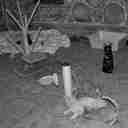

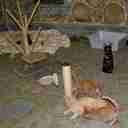

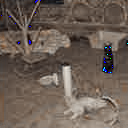

In [34]:
disp(0, mean_of_train, std_of_train, X_train, y_train, train_result)

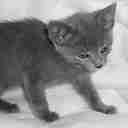

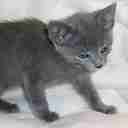

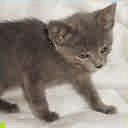

In [35]:
disp(0, mean_of_train, std_of_train, X_test, y_test, test_result)

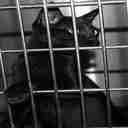

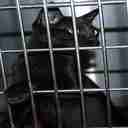

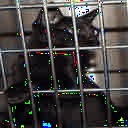

In [36]:
disp(1, mean_of_train, std_of_train, X_train, y_train, train_result)

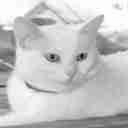

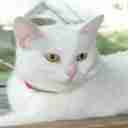

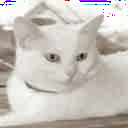

In [37]:
disp(2, mean_of_train, std_of_train, X_train, y_train, train_result)

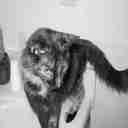

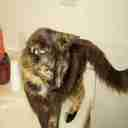

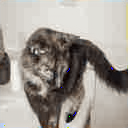

In [38]:
disp(1, mean_of_train, std_of_train, X_test, y_test, test_result)

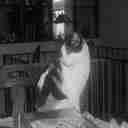

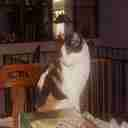

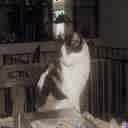

In [39]:
disp(2, mean_of_train, std_of_train, X_test, y_test, test_result)